In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

2021-12-08 19:46:36.578759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 19:46:36.578813: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


scanpy==1.8.0 anndata==0.7.6 umap==0.5.2 numpy==1.19.5 scipy==1.5.3 pandas==1.3.4 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3 pynndescent==0.5.5


In [207]:
adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/211015_annot_patient_integrated.h5ad')

In [209]:
# percentage of cells without barcode
adata[adata.obs.treatment == 'nan'].shape[0]/adata.shape[0]

0.26095627478333827

In [192]:
pd.crosstab(adata.obs.treatment, adata.obs.patient)

patient,patient_1,patient_2,patient_3,patient_4
treatment,,,,
BB94,0,0,0,3898
DMSO,0,0,0,2285
Gilteritinib,0,0,0,3932
IFNL,0,0,4520,4836
IFNa (b_d),3810,5914,4020,4760
IFNa_TNFa,3800,0,6526,4560
IFNg,3556,4242,5787,4769
IFNg_TGFb2,0,0,4389,4305
Sorafenib,3559,0,5010,5954


Without any correction.

In [84]:
dfs = []
for patient in adata.obs.patient.unique():
    df = pd.crosstab(adata.obs.treatment, adata.obs.cell_type)
    df /= df.sum(0)  # get percentage within cell type
#     df -= df.T['mock']
    df = pd.DataFrame(df.stack()).reset_index()
    df.columns = ['treatment', 'cell_type', 'percentage change']
    df['patient'] = patient
    dfs.append(df)

In [79]:
# df = pd.concat(dfs).reset_index().drop('index', axis=1)

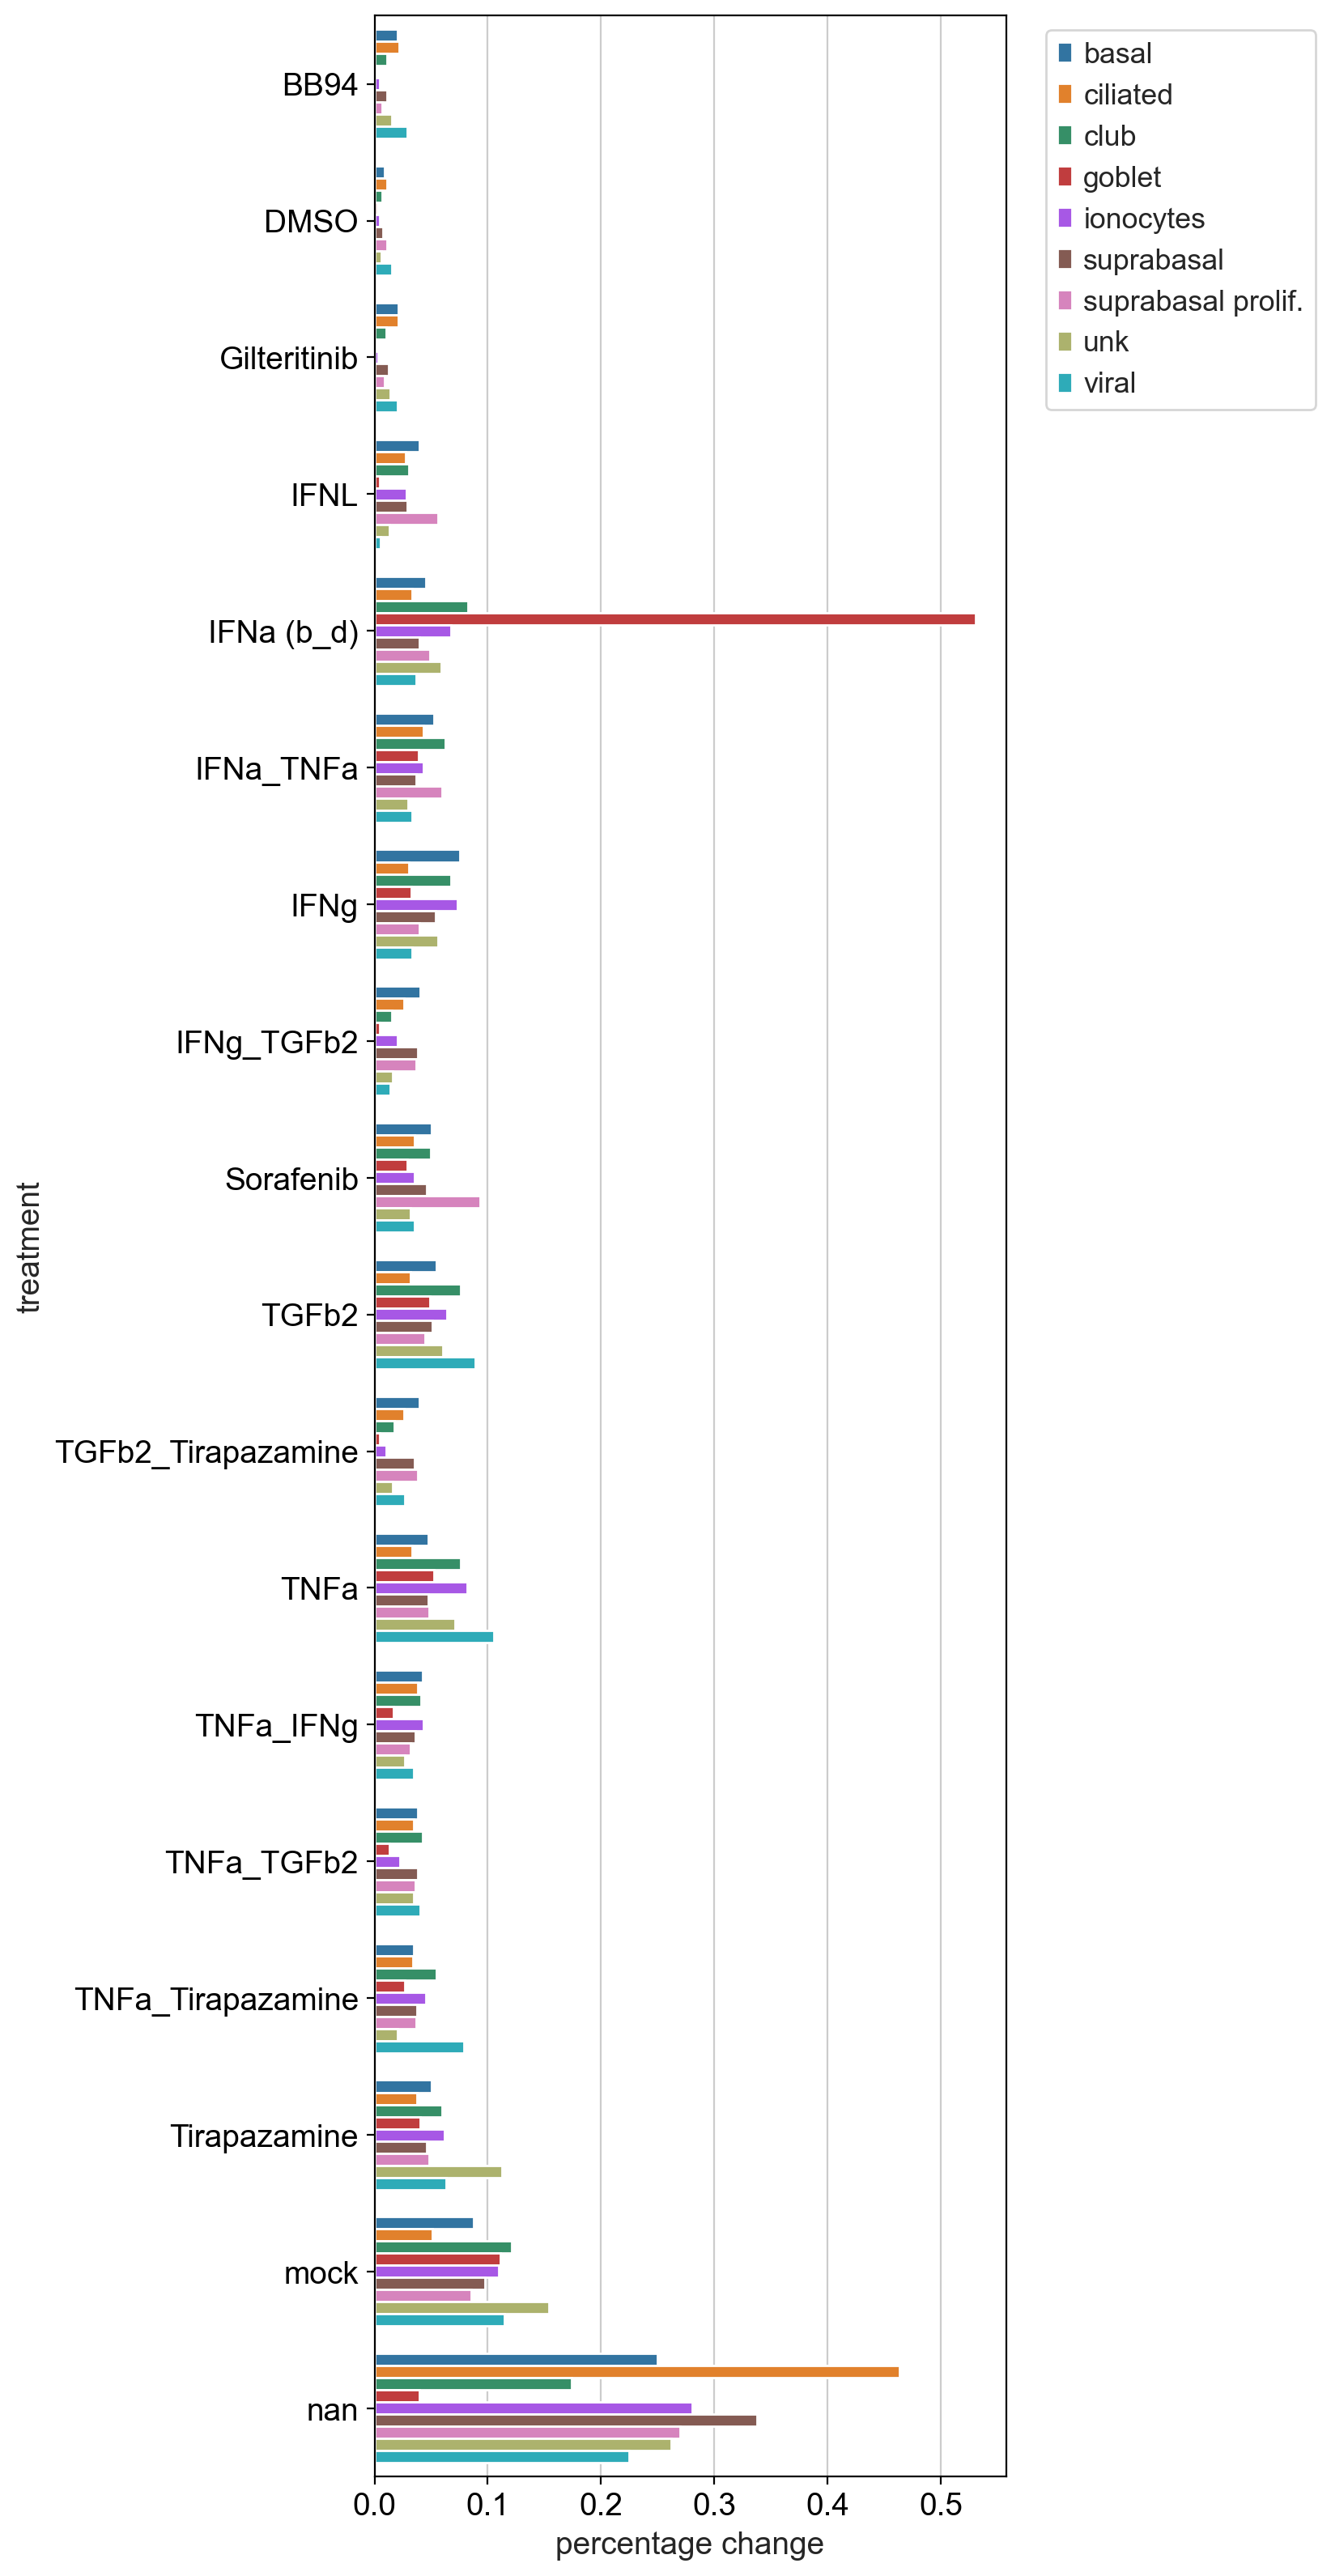

In [85]:
plt.figure(figsize = (5, 20))
sns.barplot(
    data=pd.concat(dfs),
    y='treatment',
    x='percentage change',
    hue='cell_type'
)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

## scCODA

In [139]:
adata = adata[adata.obs.treatment != 'nan']

In [177]:
# construct counts anndata
df = pd.crosstab([adata.obs.treatment, adata.obs.patient, adata.obs.infected], adata.obs.cell_type).reset_index()
df['treatment_patient_infected'] = df['treatment'].astype(str) + '-' + df['patient'].astype(str) + '-' + df['infected'].astype(str)
data_all = dat.from_pandas(
    df.drop(['treatment', 'patient', 'infected'], axis=1),
    covariate_columns=["treatment_patient_infected"]
)

# split out variables
data_all.obs['treatment'] = [x.split('-')[0] for x in data_all.obs['treatment_patient_infected']]
data_all.obs['patient'] = [x.split('-')[1] for x in data_all.obs['treatment_patient_infected']]
data_all.obs['infected'] = [x.split('-')[2] for x in data_all.obs['treatment_patient_infected']]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


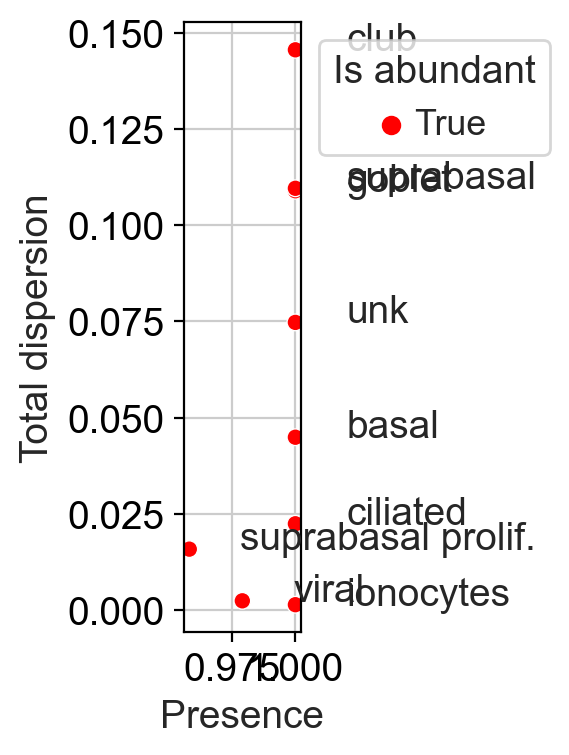

In [143]:
# visualize to find a reference cell type
viz.rel_abundance_dispersion_plot(
    data=data_all,
    abundant_threshold=0.9,
    figsize=(4, 4)
)
plt.show()

### infection based models

<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

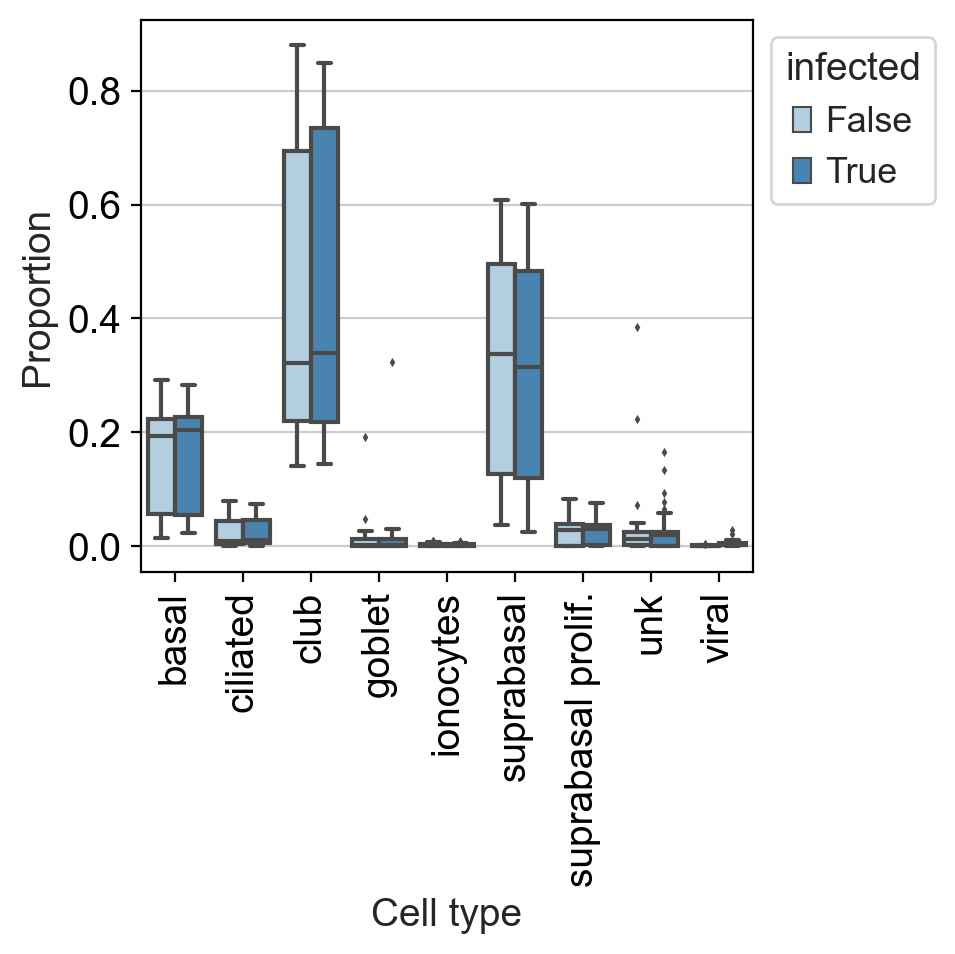

In [181]:
viz.boxplots(data_all, feature_name="infected", figsize=(5, 5))

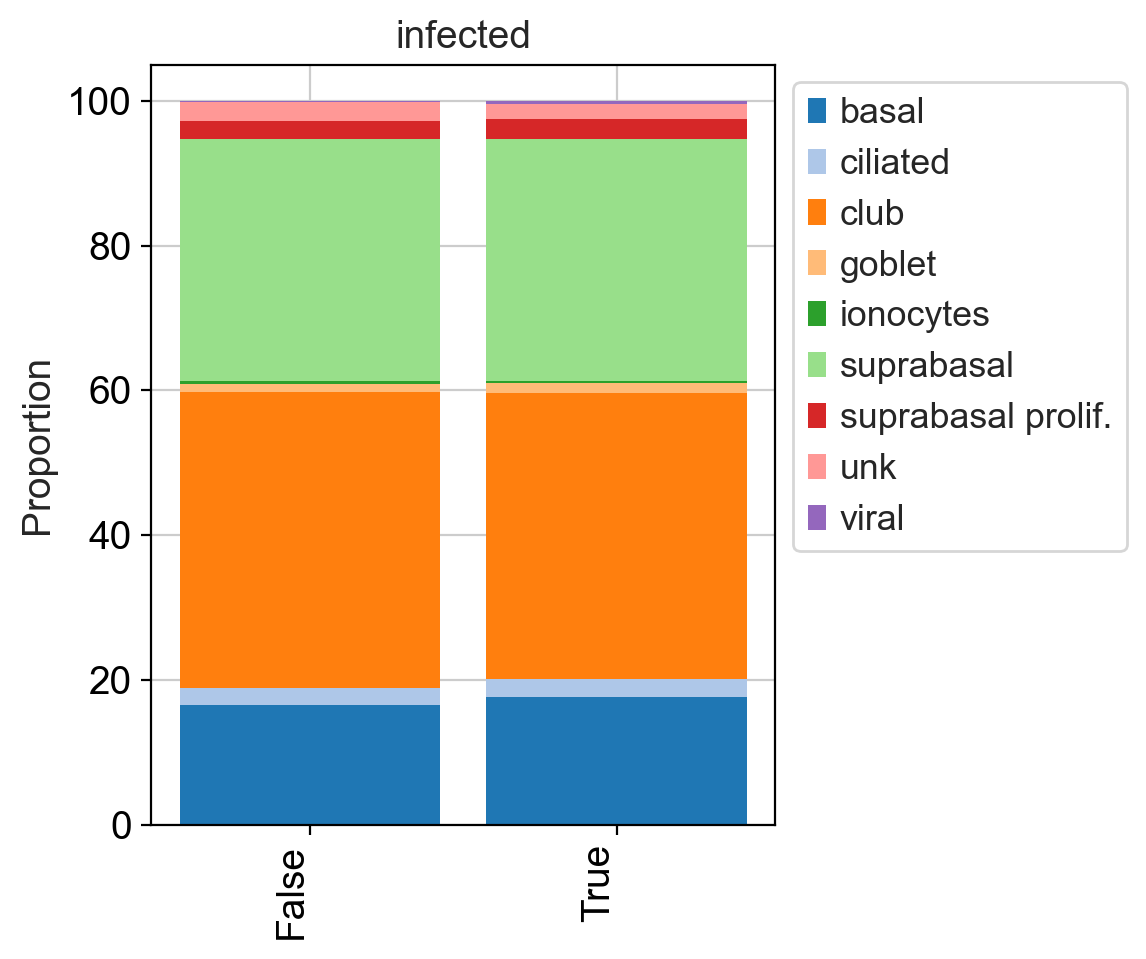

In [180]:
g = viz.stacked_barplot(data_all, feature_name="infected", figsize=(4, 5))
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha='right')
plt.show()

In [182]:
model = mod.CompositionalAnalysis(data_all, formula="infected", reference_cell_type="automatic")
sim_results = model.sample_hmc()

Automatic reference selection! Reference cell type set to ionocytes
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:54<00:00, 42.11it/s]


MCMC sampling finished. (597.508 sec)
Acceptance rate: 46.3%


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [183]:
sim_results.save('2021-11-10_scCODA_infected')

In [184]:
sim_results.summary();

Compositional Analysis summary:

Data: 95 samples, 9 cell types
Reference index: 4
Formula: infected

Intercepts:
                    Final Parameter  Expected Sample
Cell Type                                           
basal                         0.643       368.240834
ciliated                     -0.694        96.711969
club                          1.533       896.714174
goblet                       -1.172        59.963567
ionocytes                    -1.266        54.583802
suprabasal                    1.194       638.893111
suprabasal prolif.           -0.808        86.292023
unk                          -0.813        85.861640
viral                        -1.365        49.438880


Effects:
                                     Final Parameter  Expected Sample  \
Covariate        Cell Type                                              
infected[T.True] basal                           0.0       368.240834   
                 ciliated                        0.0        96.711969   


In [185]:
sim_results.set_fdr(est_fdr=0.1)
sim_results.effect_df[sim_results.effect_df['Final Parameter'] != 0]  # significant

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample,log2-fold change
Covariate,Cell Type,,,,,,,


Infection did not have a significant effect on cell type proportions, as we also see from the abundances above.

### treatment based models

<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

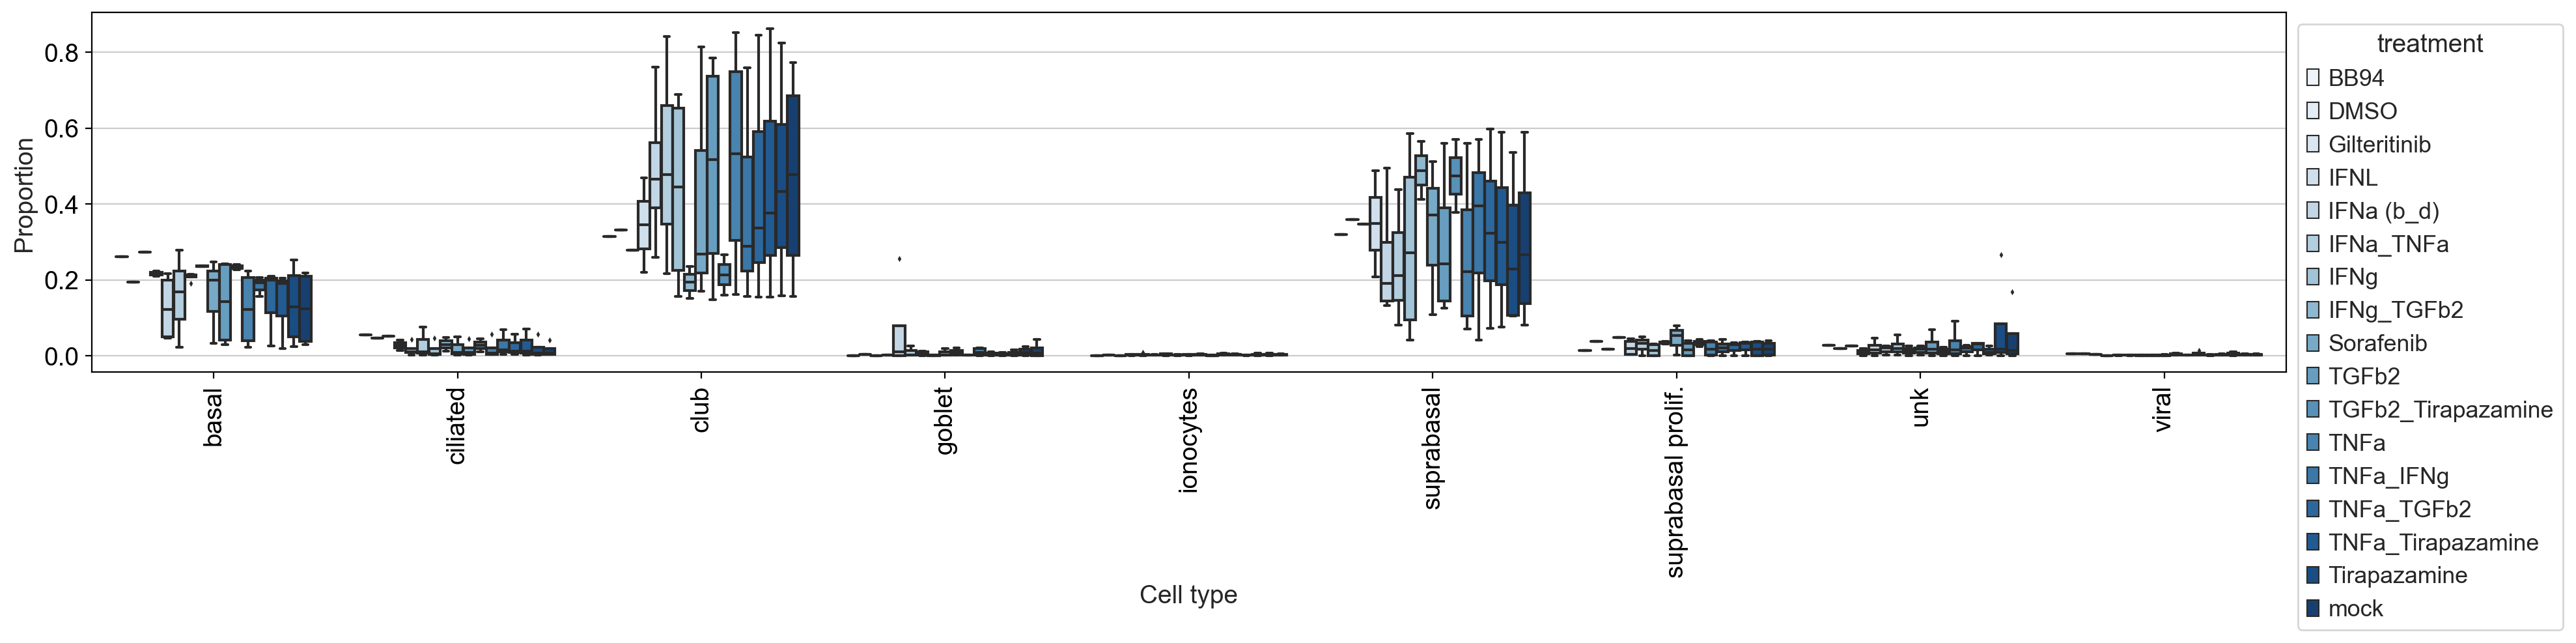

In [141]:
viz.boxplots(data_all, feature_name="treatment", figsize=(20, 5))

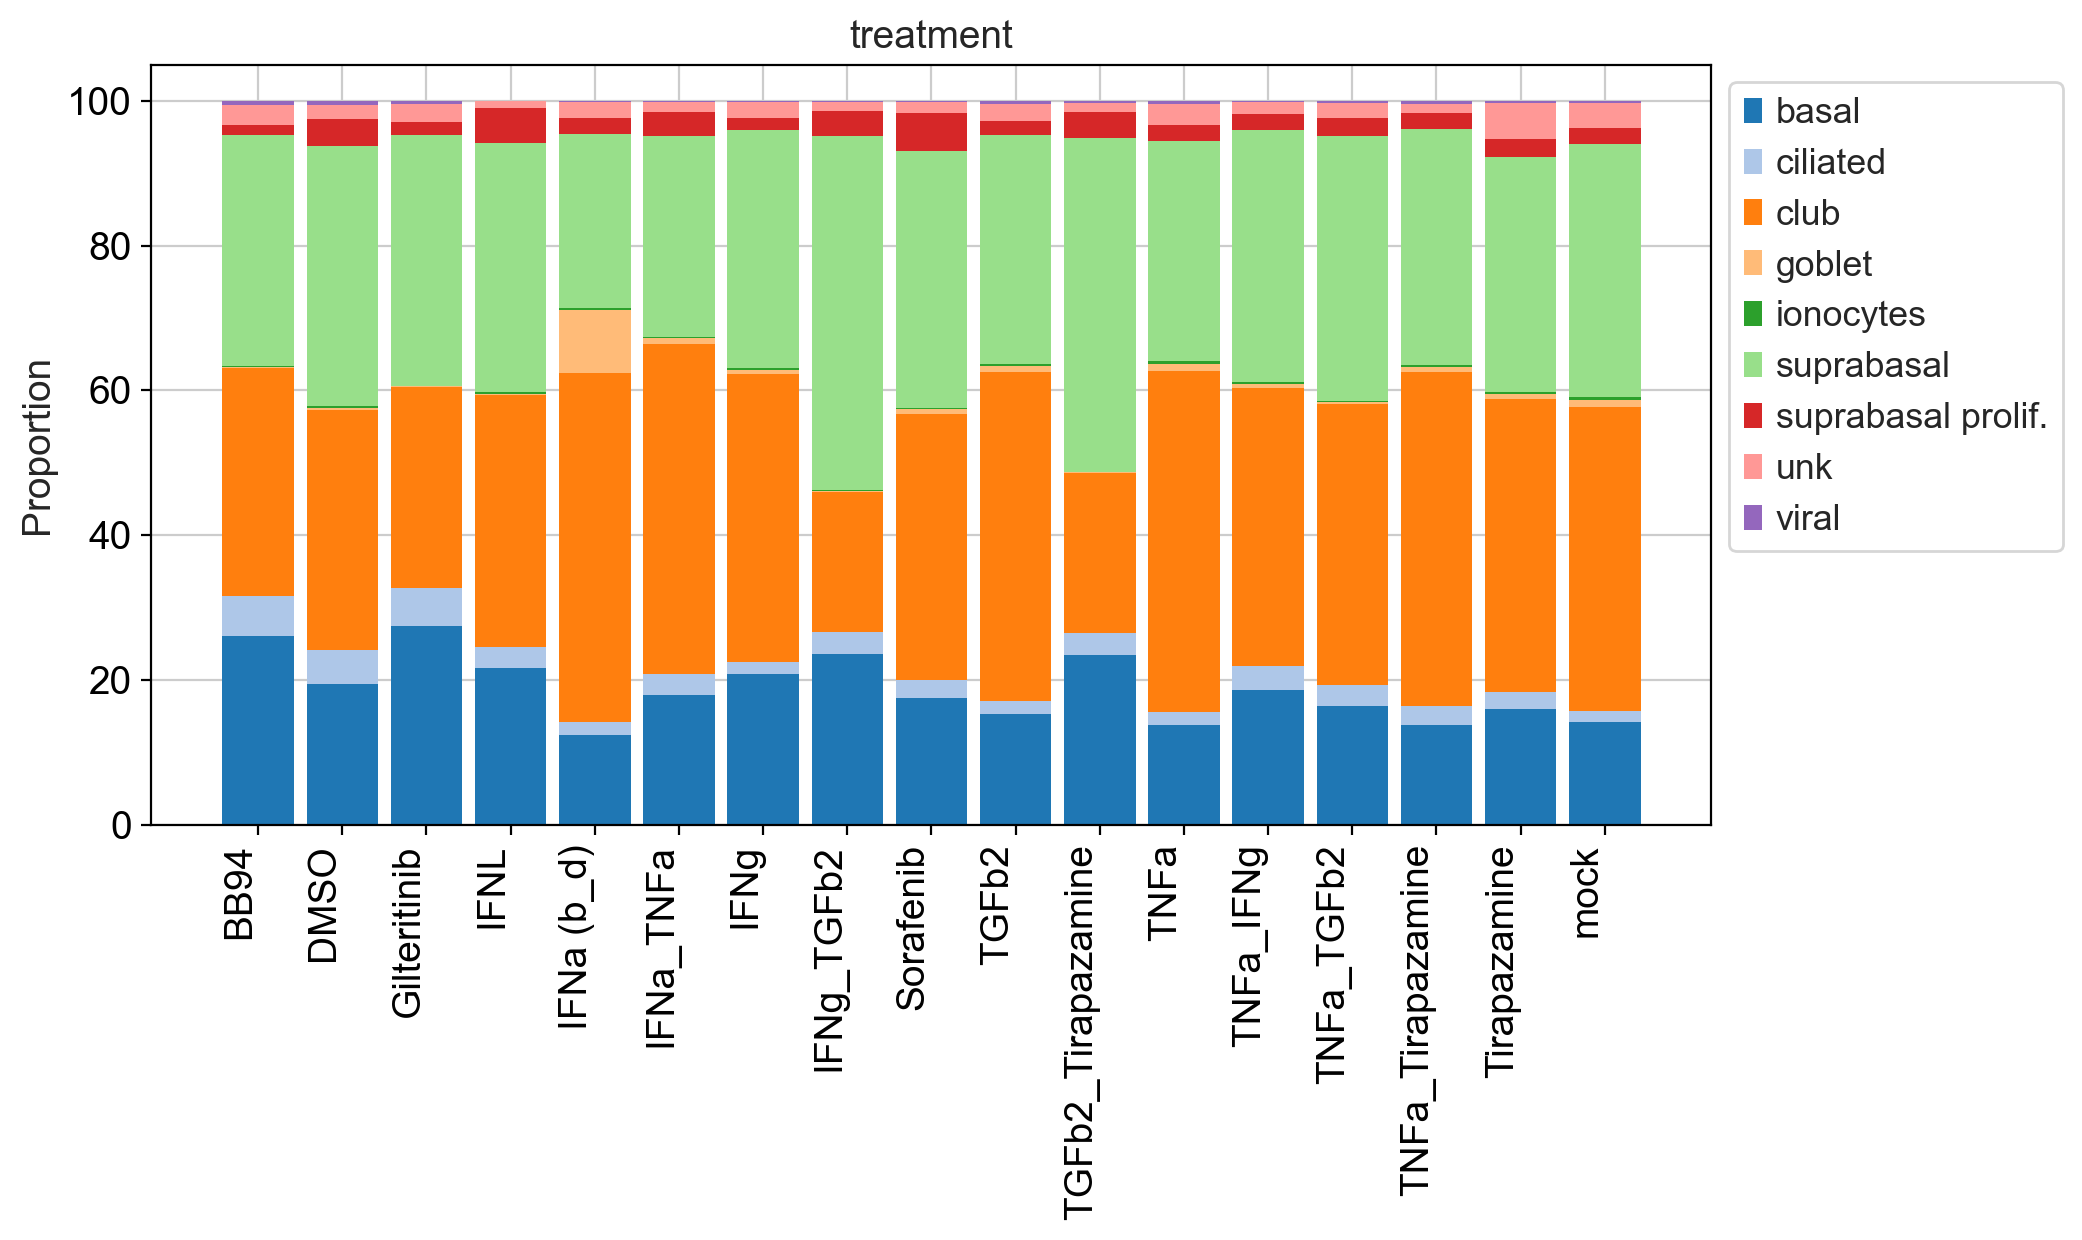

In [142]:
g = viz.stacked_barplot(data_all, feature_name="treatment", figsize=(10, 5))
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha='right')
plt.show()

The same, but split by infection.

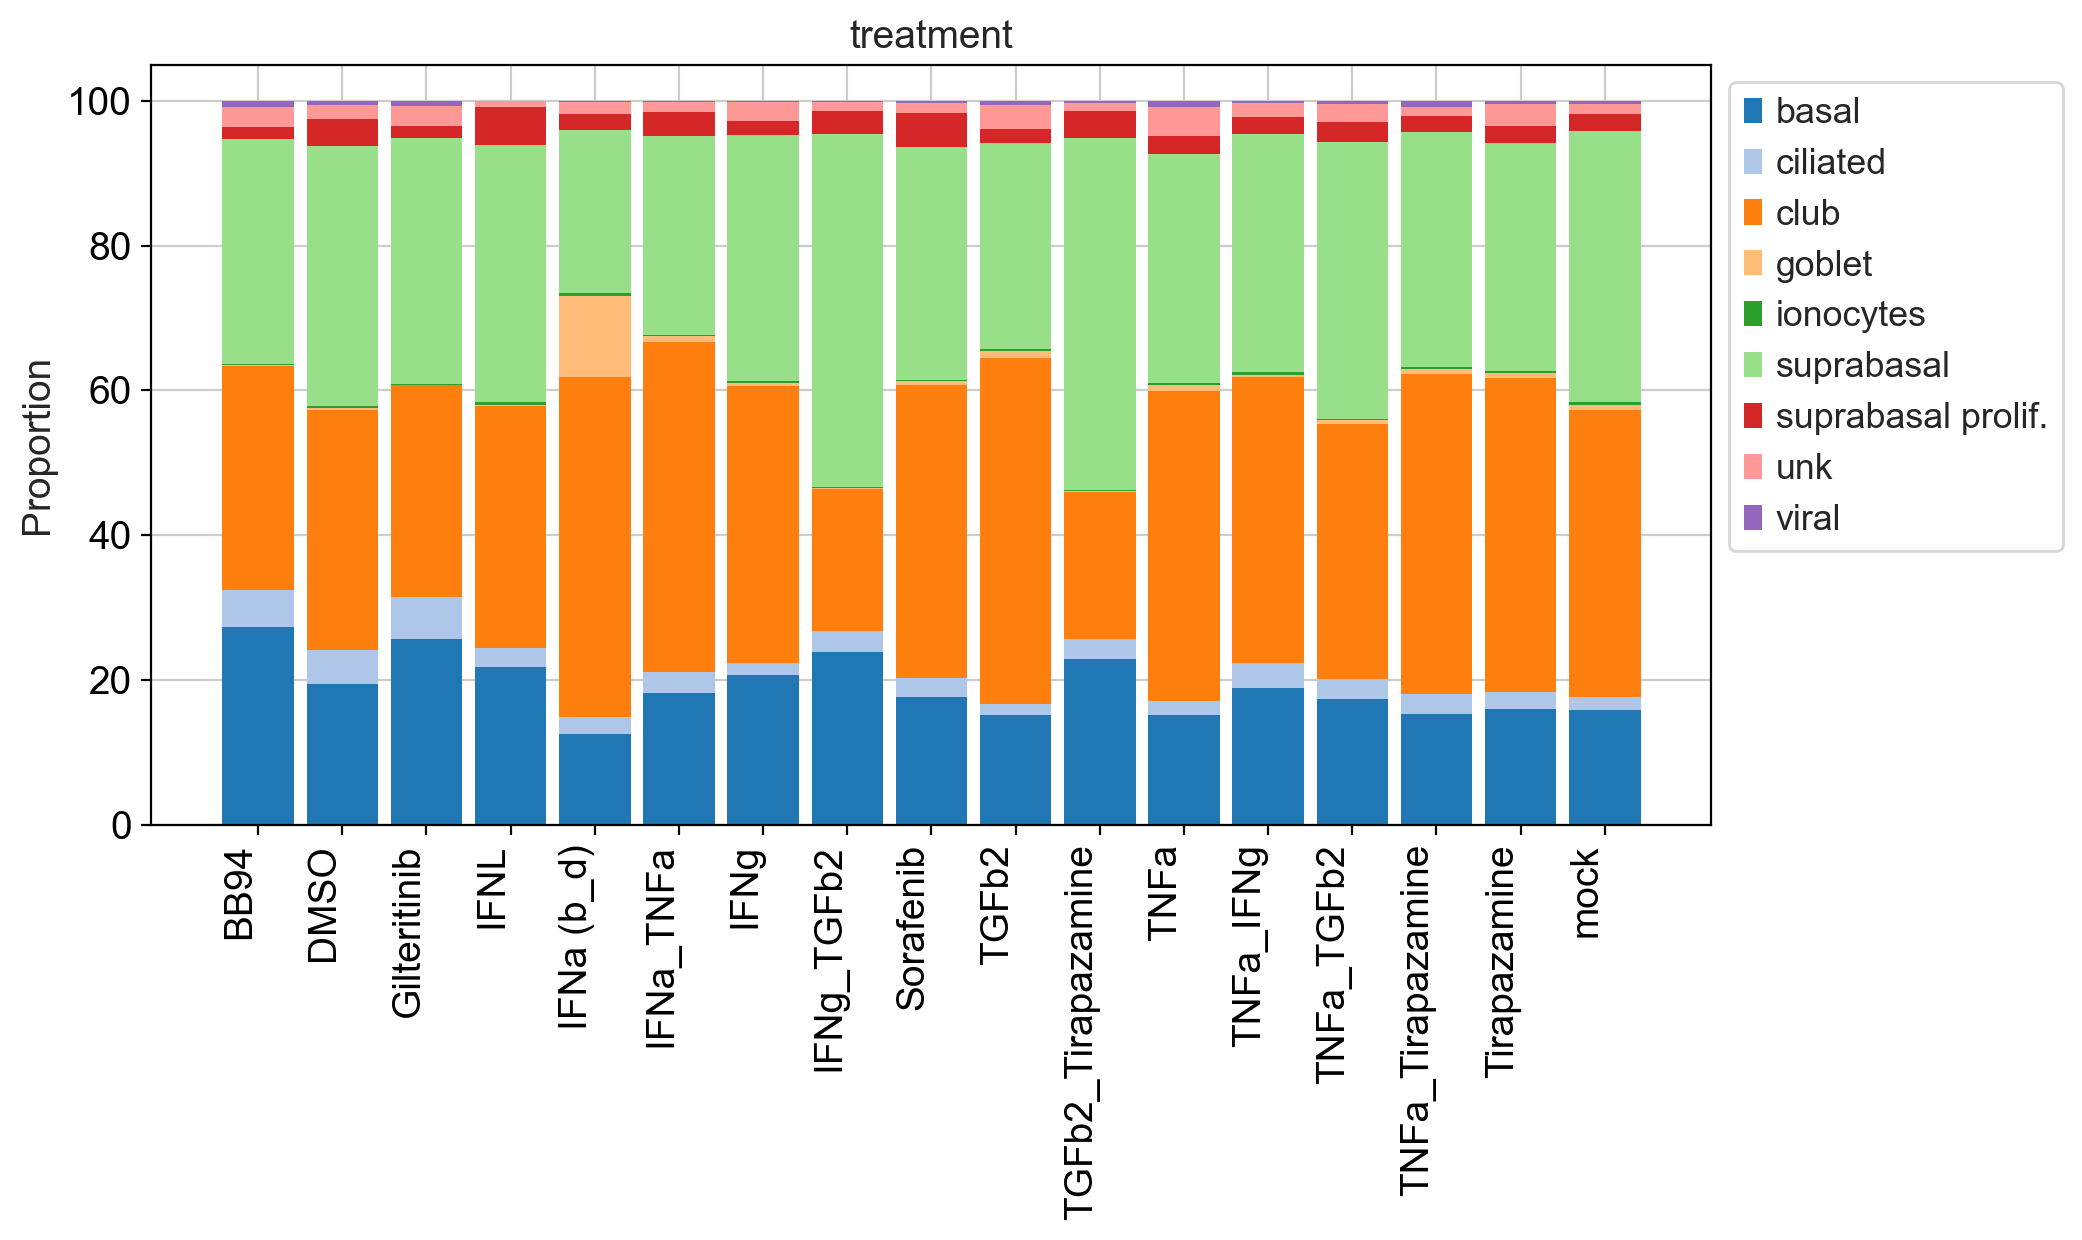

In [198]:
g = viz.stacked_barplot(data_all[data_all.obs.infected == 'True'], feature_name="treatment", figsize=(10, 5))
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha='right')
plt.show()

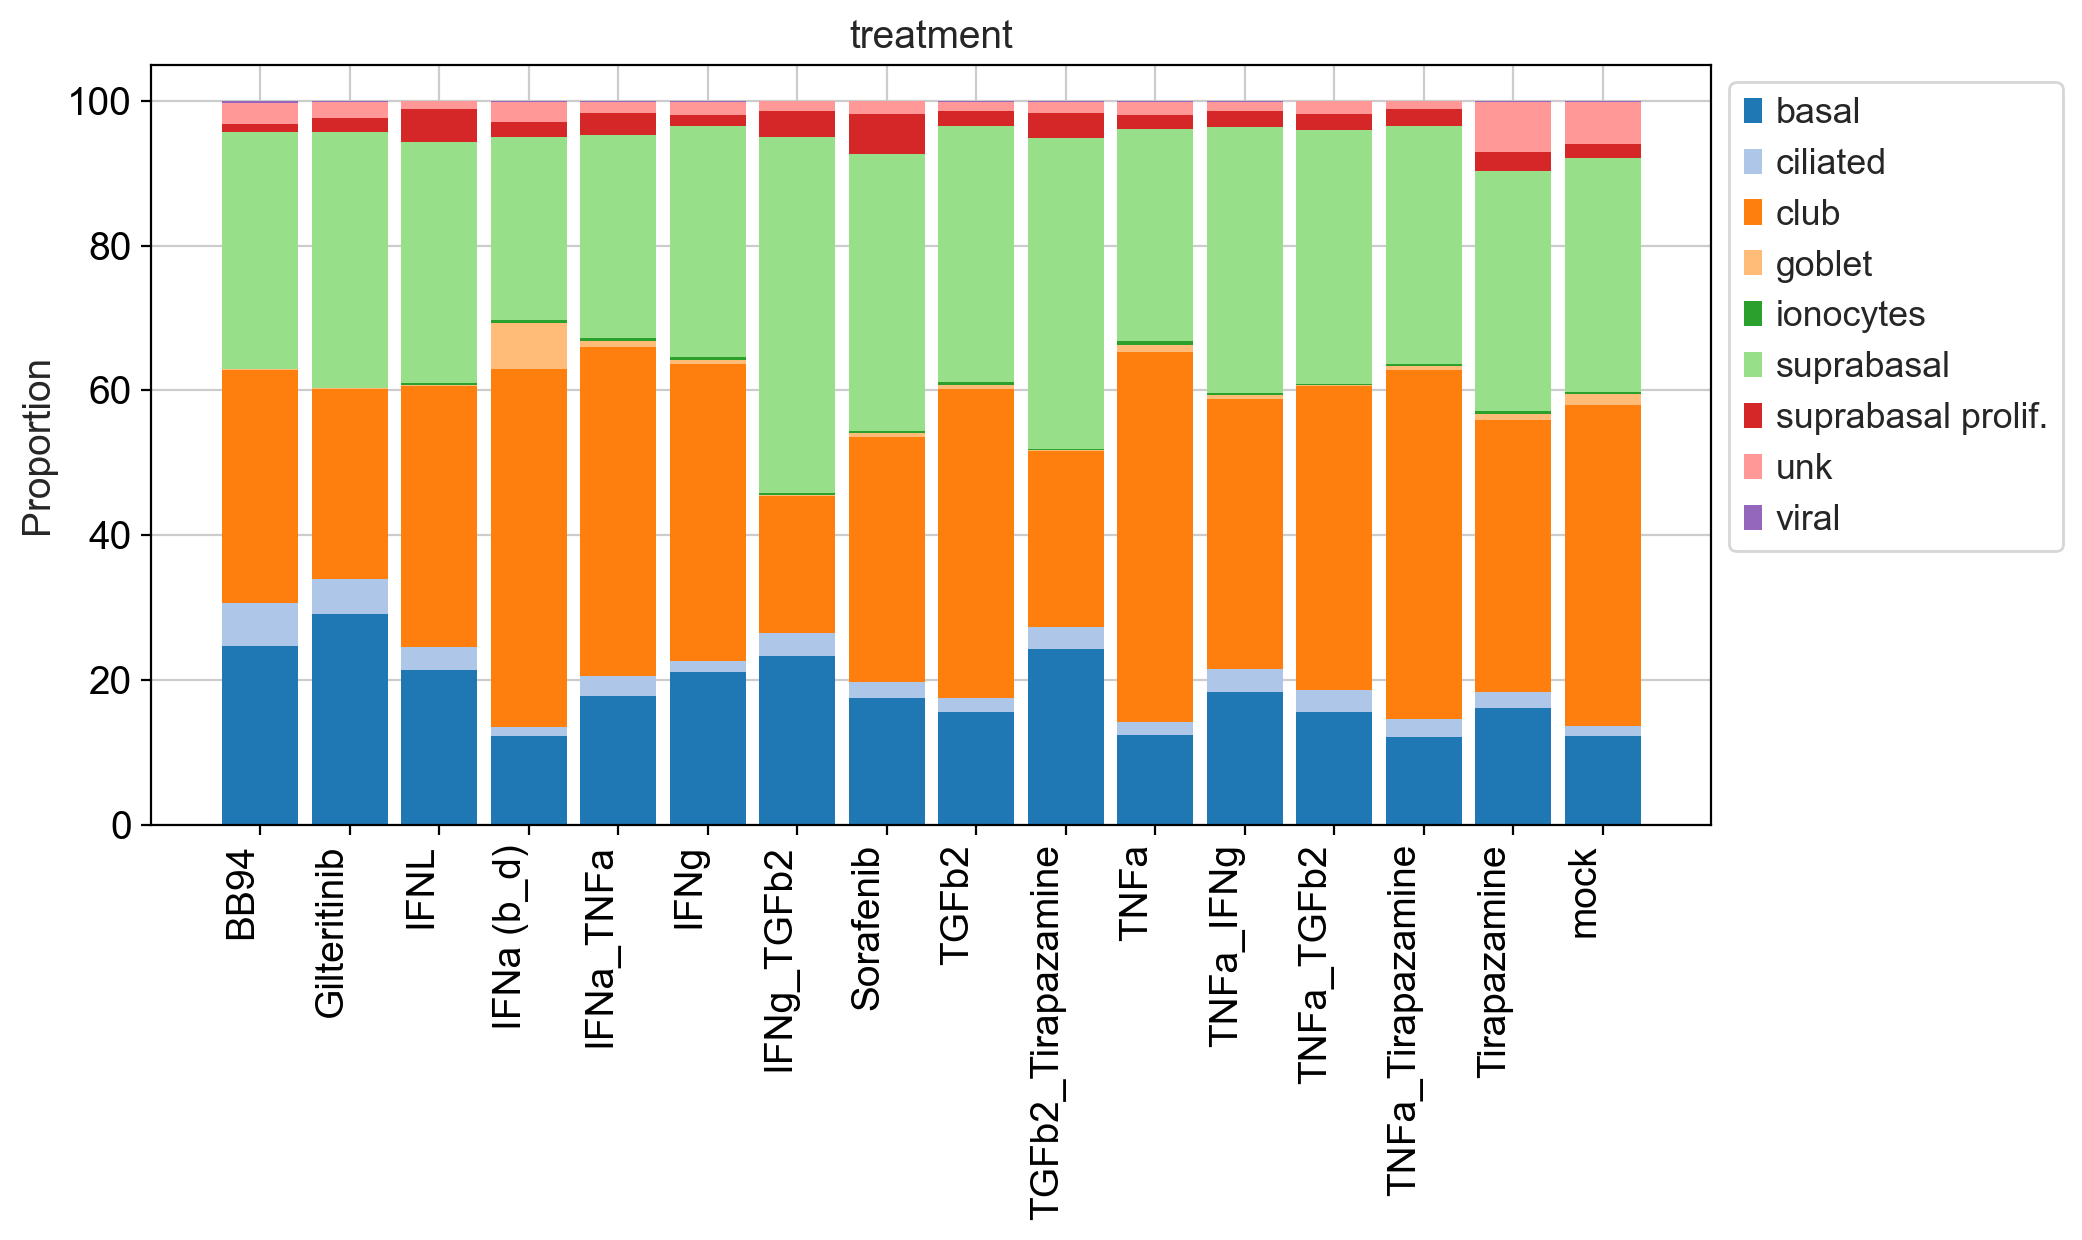

In [199]:
g = viz.stacked_barplot(data_all[data_all.obs.infected == 'False'], feature_name="treatment", figsize=(10, 5))
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha='right')
plt.show()

Train a model to quantify the compositional change and estimate significance.

In [ ]:
model = mod.CompositionalAnalysis(data_all, formula="treatment", reference_cell_type="automatic")
sim_results = model.sample_hmc()

In [175]:
sim_results.save('2021-11-10_scCODA_treatment')

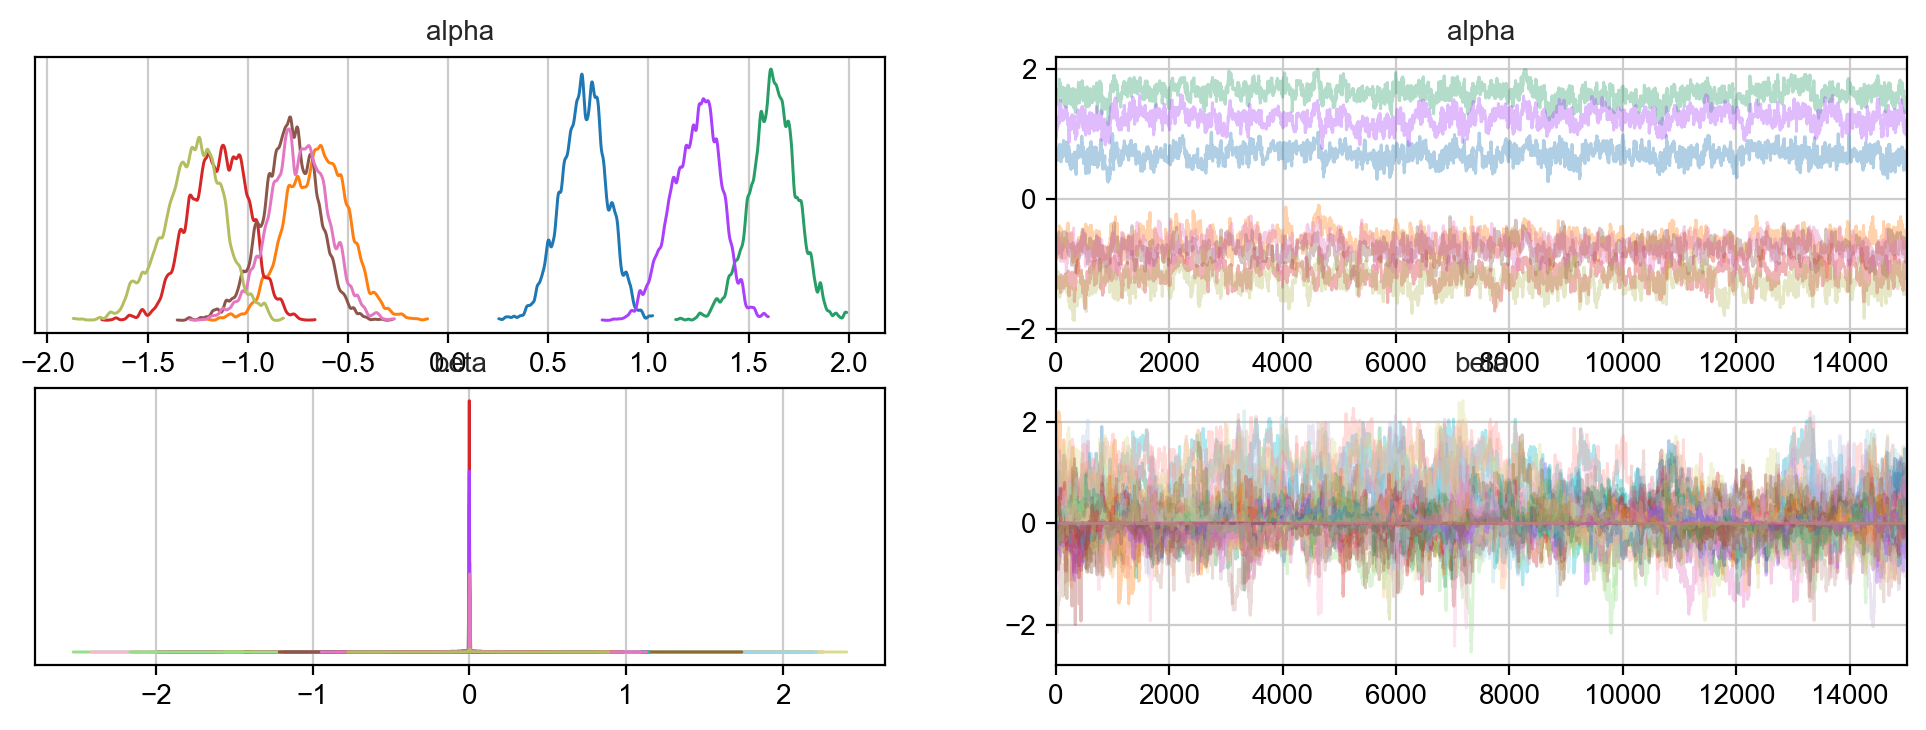

In [153]:
import arviz as az
az.plot_trace(
    sim_results,
    divergences=False,
    var_names=["alpha", "beta"],
    coords={"cell_type": sim_results.posterior.coords["cell_type_nb"]},
)
plt.show()

Generate the effect and intercept dfs.

In [169]:
sim_results.summary();

Compositional Analysis summary:

Data: 48 samples, 9 cell types
Reference index: 4
Formula: treatment

Intercepts:
                    Final Parameter  Expected Sample
Cell Type                                           
basal                         0.677       710.653689
ciliated                     -0.655       187.576214
club                          1.621      1826.551854
goblet                       -1.146       114.799283
ionocytes                    -1.205       108.222061
suprabasal                    1.235      1241.636114
suprabasal prolif.           -0.793       163.397394
unk                          -0.749       170.747394
viral                        -1.275       100.905581


Effects:
                                      Final Parameter  Expected Sample  \
Covariate         Cell Type                                              
treatment[T.DMSO] basal                           0.0       710.653689   
                  ciliated                        0.0       187.57621

In [171]:
sim_results.effect_df[sim_results.effect_df['Final Parameter'] != 0]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample,log2-fold change
Covariate,Cell Type,,,,,,,
treatment[T.IFNg_TGFb2],suprabasal,0.977527,0.125,1.808,0.489,0.964533,2283.617293,0.879078


Set a different FDR threshold.

In [170]:
sim_results.set_fdr(est_fdr=0.1)
sim_results.effect_df[sim_results.effect_df['Final Parameter'] != 0]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Final Parameter  HDI 3%  HDI 97%  \
Covariate                       Cell Type                                      
treatment[T.IFNg]               suprabasal        -0.149885  -0.633    0.163   
treatment[T.IFNg_TGFb2]         basal              0.813120  -0.206    1.773   
                                suprabasal         0.977527   0.125    1.808   
treatment[T.TGFb2_Tirapazamine] suprabasal         0.760744  -0.188    1.702   

                                               SD  Inclusion probability  \
Covariate                       Cell Type                                  
treatment[T.IFNg]               suprabasal  0.200               0.847733   
treatment[T.IFNg_TGFb2]         basal       0.610               0.886867   
                                suprabasal  0.489               0.964533   
treatment[T.TGFb2_Tirapazamine] suprabasal  0.560               0.927133   

                                            Expected Sample  log2-fold change  
Covariate                       Cell Type                                      
treatment[T.IFNg]               suprabasal      1110.303725         -0.161288  
treatment[T.IFNg_TGFb2]         basal            978.328642          0.461172  
                                suprabasal      2014.754299          0.698361  
treatment[T.TGFb2_Tirapazamine] suprabasal      2034.338507          0.712317

#### per treatment results

In [ ]:
results = {}
for t in adata.obs.treatment.unique():
    data_t = data_all[data_all.obs["treatment"].isin(["mock", t])]
    model_t = mod.CompositionalAnalysis(data_all, formula=f"C(treatment, Treatment('{t}'))", reference_cell_type="automatic")
    print(t)
    results[t] = model_t.sample_hmc()

Automatic reference selection! Reference cell type set to ionocytes
Zero counts encountered in data! Added a pseudocount of 0.5.
TNFa_IFNg


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:51<00:00, 37.61it/s]


MCMC sampling finished. (662.540 sec)
Acceptance rate: 44.9%


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Automatic reference selection! Reference cell type set to ionocytes
Zero counts encountered in data! Added a pseudocount of 0.5.
IFNa (b_d)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:41<00:00, 38.36it/s]


MCMC sampling finished. (651.979 sec)
Acceptance rate: 52.8%


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Automatic reference selection! Reference cell type set to ionocytes
Zero counts encountered in data! Added a pseudocount of 0.5.
IFNg


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:37<00:00, 38.67it/s]


MCMC sampling finished. (645.352 sec)
Acceptance rate: 38.1%


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Automatic reference selection! Reference cell type set to ionocytes
Zero counts encountered in data! Added a pseudocount of 0.5.
Tirapazamine


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:13<00:00, 40.56it/s]


MCMC sampling finished. (607.288 sec)
Acceptance rate: 32.5%


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Automatic reference selection! Reference cell type set to ionocytes
Zero counts encountered in data! Added a pseudocount of 0.5.
mock


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:37<00:00, 43.71it/s]


MCMC sampling finished. (572.795 sec)
Acceptance rate: 49.1%


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Automatic reference selection! Reference cell type set to ionocytes
Zero counts encountered in data! Added a pseudocount of 0.5.
IFNa_TNFa


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:58<00:00, 41.81it/s]


MCMC sampling finished. (608.680 sec)
Acceptance rate: 58.3%


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Automatic reference selection! Reference cell type set to ionocytes
Zero counts encountered in data! Added a pseudocount of 0.5.
TNFa


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:30<00:00, 39.21it/s]


MCMC sampling finished. (639.490 sec)
Acceptance rate: 36.2%


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Automatic reference selection! Reference cell type set to ionocytes
Zero counts encountered in data! Added a pseudocount of 0.5.
Sorafenib


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:41<00:00, 38.34it/s]


MCMC sampling finished. (651.506 sec)
Acceptance rate: 56.1%


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Automatic reference selection! Reference cell type set to ionocytes
Zero counts encountered in data! Added a pseudocount of 0.5.
TNFa_Tirapazamine


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:35<00:00, 38.80it/s]


MCMC sampling finished. (645.888 sec)
Acceptance rate: 58.2%


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Automatic reference selection! Reference cell type set to ionocytes
Zero counts encountered in data! Added a pseudocount of 0.5.
TGFb2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:43<00:00, 38.20it/s]


MCMC sampling finished. (651.514 sec)
Acceptance rate: 50.1%


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Automatic reference selection! Reference cell type set to ionocytes
Zero counts encountered in data! Added a pseudocount of 0.5.
TNFa_TGFb2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:46<00:00, 37.97it/s]


MCMC sampling finished. (656.218 sec)
Acceptance rate: 58.2%


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Automatic reference selection! Reference cell type set to ionocytes
Zero counts encountered in data! Added a pseudocount of 0.5.
TGFb2_Tirapazamine


 32%|██████████████████████████████████████████████████████████████████▌                                                                                                                                               | 6339/20000 [02:44<05:52, 38.72it/s]

In [190]:
for k, res in results.items():
    print(k)
    display(res.effect_df[res.effect_df['Final Parameter'] != 0])

TNFa_IFNg


Final Parameter  \
Covariate                                          Cell Type                             
C(treatment, Treatment('TNFa_IFNg'))[T.BB94]       basal                      0.272160   
                                                   suprabasal                 0.323226   
C(treatment, Treatment('TNFa_IFNg'))[T.DMSO]       suprabasal prolif.         0.019907   
C(treatment, Treatment('TNFa_IFNg'))[T.Gilterit... ciliated                   0.158369   
C(treatment, Treatment('TNFa_IFNg'))[T.IFNL]       unk                       -0.149611   
C(treatment, Treatment('TNFa_IFNg'))[T.IFNa_TNFa]  club                       0.142274   
C(treatment, Treatment('TNFa_IFNg'))[T.IFNg]       ciliated                  -0.046456   
C(treatment, Treatment('TNFa_IFNg'))[T.IFNg_TGFb2] basal                      2.076776   
                                                   ciliated                   1.271569   
                                                   club                       0.923581   
                                                   suprabasal                 2.280696   
                                                   suprabasal prolif.         1.638209   
C(treatment, Treatment('TNFa_IFNg'))[T.TGFb2_Ti... basal                      1.430361   
                                                   suprabasal                 1.601149   
                                                   suprabasal prolif.         0.902846   

                                                                       HDI 3%  \
Covariate                                          Cell Type                    
C(treatment, Treatment('TNFa_IFNg'))[T.BB94]       basal               -0.336   
                                                   suprabasal          -0.204   
C(treatment, Treatment('TNFa_IFNg'))[T.DMSO]       suprabasal prolif.  -0.755   
C(treatment, Treatment('TNFa_IFNg'))[T.Gilterit... ciliated            -0.306   
C(treatment, Treatment('TNFa_IFNg'))[T.IFNL]       unk                 -0.798   
C(treatment, Treatment('TNFa_IFNg'))[T.IFNa_TNFa]  club                -0.055   
C(treatment, Treatment('TNFa_IFNg'))[T.IFNg]       ciliated            -0.326   
C(treatment, Treatment('TNFa_IFNg'))[T.IFNg_TGFb2] basal                1.402   
                                                   ciliated             0.436   
                                                   club                 0.291   
                                                   suprabasal           1.634   
                                                   suprabasal prolif.   0.835   
C(treatment, Treatment('TNFa_IFNg'))[T.TGFb2_Ti... basal                0.550   
                                                   suprabasal           0.821   
                                                   suprabasal prolif.  -0.353   

                                                                       HDI 97%  \
Covariate                                          Cell Type                     
C(treatment, Treatment('TNFa_IFNg'))[T.BB94]       basal                 1.083   
                                                   suprabasal            1.014   
C(treatment, Treatment('TNFa_IFNg'))[T.DMSO]       suprabasal prolif.    0.943   
C(treatment, Treatment('TNFa_IFNg'))[T.Gilterit... ciliated              0.807   
C(treatment, Treatment('TNFa_IFNg'))[T.IFNL]       unk                   0.488   
C(treatment, Treatment('TNFa_IFNg'))[T.IFNa_TNFa]  club                  0.420   
C(treatment, Treatment('TNFa_IFNg'))[T.IFNg]       ciliated              0.204   
C(treatment, Treatment('TNFa_IFNg'))[T.IFNg_TGFb2] basal                 2.796   
                                                   ciliated              2.026   
                                                   club                  1.556   
                                                   suprabasal            2.939   
                                                   suprabasal prolif.    2.384   
C(treatment, T

IFNa (b_d)


Final Parameter  \
Covariate                                          Cell Type                             
C(treatment, Treatment('IFNa (b_d)'))[T.IFNL]      suprabasal                 0.310276   
C(treatment, Treatment('IFNa (b_d)'))[T.IFNg_TG... basal                      1.570322   
                                                   suprabasal                 1.773938   
C(treatment, Treatment('IFNa (b_d)'))[T.TGFb2_T... basal                      1.553188   
                                                   suprabasal                 1.723286   
                                                   suprabasal prolif.         1.146038   
C(treatment, Treatment('IFNa (b_d)'))[T.TNFa_Ti... goblet                    -0.016317   

                                                                       HDI 3%  \
Covariate                                          Cell Type                    
C(treatment, Treatment('IFNa (b_d)'))[T.IFNL]      suprabasal          -0.026   
C(treatment, Treatment('IFNa (b_d)'))[T.IFNg_TG... basal                0.744   
                                                   suprabasal           0.914   
C(treatment, Treatment('IFNa (b_d)'))[T.TGFb2_T... basal                0.650   
                                                   suprabasal           0.910   
                                                   suprabasal prolif.   0.148   
C(treatment, Treatment('IFNa (b_d)'))[T.TNFa_Ti... goblet              -0.332   

                                                                       HDI 97%  \
Covariate                                          Cell Type                     
C(treatment, Treatment('IFNa (b_d)'))[T.IFNL]      suprabasal            0.715   
C(treatment, Treatment('IFNa (b_d)'))[T.IFNg_TG... basal                 2.562   
                                                   suprabasal            2.697   
C(treatment, Treatment('IFNa (b_d)'))[T.TGFb2_T... basal                 2.441   
                                                   suprabasal            2.530   
                                                   suprabasal prolif.    2.239   
C(treatment, Treatment('IFNa (b_d)'))[T.TNFa_Ti... goblet                0.274   

                                                                          SD  \
Covariate                                          Cell Type                   
C(treatment, Treatment('IFNa (b_d)'))[T.IFNL]      suprabasal          0.240   
C(treatment, Treatment('IFNa (b_d)'))[T.IFNg_TG... basal               0.526   
                                                   suprabasal          0.513   
C(treatment, Treatment('IFNa (b_d)'))[T.TGFb2_T... basal               0.495   
                                                   suprabasal          0.459   
                                                   suprabasal prolif.  0.575   
C(treatment, Treatment('IFNa (b_d)'))[T.TNFa_Ti... goblet              0.146   

                                                                       Inclusion probability  \
Covariate                                          Cell Type                                   
C(treatment, Treatment('IFNa (b_d)'))[T.IFNL]      suprabasal                         0.8844   
C(treatment, Treatment('IFNa (b_d)'))[T.IFNg_TG... basal                              1.0000   
                                                   suprabasal                         1.0000   
C(treatment, Treatment('IFNa (b_d)'))[T.TGFb2_T... basal                              1.0000   
                                                   suprabasal                         1.0000   
                                                   suprabasal prolif.                 1.0000   
C(treatment, Treatment('IFNa (b_d)'))[T.TNFa_Ti... goblet                             0.8644   

                                                                       Expected Sample  \
Covariate                                          Cell Type                             
C(treatment, Treatment('I

IFNg


Final Parameter  \
Covariate                                          Cell Type                     
C(treatment, Treatment('IFNg'))[T.IFNg_TGFb2]      basal              1.197569   
                                                   suprabasal         1.386463   
C(treatment, Treatment('IFNg'))[T.TGFb2_Tirapaz... suprabasal         1.016876   

                                                               HDI 3%  \
Covariate                                          Cell Type            
C(treatment, Treatment('IFNg'))[T.IFNg_TGFb2]      basal       -0.351   
                                                   suprabasal   0.424   
C(treatment, Treatment('IFNg'))[T.TGFb2_Tirapaz... suprabasal  -0.079   

                                                               HDI 97%     SD  \
Covariate                                          Cell Type                    
C(treatment, Treatment('IFNg'))[T.IFNg_TGFb2]      basal         2.220  0.713   
                                                   suprabasal    2.450  0.576   
C(treatment, Treatment('IFNg'))[T.TGFb2_Tirapaz... suprabasal    2.012  0.620   

                                                               Inclusion probability  \
Covariate                                          Cell Type                           
C(treatment, Treatment('IFNg'))[T.IFNg_TGFb2]      basal                    0.913667   
                                                   suprabasal               1.000000   
C(treatment, Treatment('IFNg'))[T.TGFb2_Tirapaz... suprabasal               0.989733   

                                                               Expected Sample  \
Covariate                                          Cell Type                     
C(treatment, Treatment('IFNg'))[T.IFNg_TGFb2]      basal            569.972247   
                                                   suprabasal      1129.445181   
C(treatment, Treatment('IFNg'))[T.TGFb2_Tirapaz... suprabasal      1147.108841   

                                                               log2-fold change  
Covariate                                          Cell Type                     
C(treatment, Treatment('IFNg'))[T.IFNg_TGFb2]      basal               0.629813  
                                                   suprabasal          0.902330  
C(treatment, Treatment('IFNg'))[T.TGFb2_Tirapaz... suprabasal          0.924718

Tirapazamine


Final Parameter  \
Covariate                                          Cell Type                             
C(treatment, Treatment('Tirapazamine'))[T.IFNg_... basal                      2.098890   
                                                   ciliated                   1.246592   
                                                   club                       0.997561   
                                                   suprabasal                 2.258831   
                                                   suprabasal prolif.         1.723654   
C(treatment, Treatment('Tirapazamine'))[T.Soraf... viral                     -0.141688   
C(treatment, Treatment('Tirapazamine'))[T.TGFb2... basal                      1.423582   
                                                   suprabasal                 1.571624   
C(treatment, Treatment('Tirapazamine'))[T.TNFa]    club                       0.092733   

                                                                       HDI 3%  \
Covariate                                          Cell Type                    
C(treatment, Treatment('Tirapazamine'))[T.IFNg_... basal                1.130   
                                                   ciliated             0.179   
                                                   club                 0.368   
                                                   suprabasal           1.365   
                                                   suprabasal prolif.   0.932   
C(treatment, Treatment('Tirapazamine'))[T.Soraf... viral               -0.581   
C(treatment, Treatment('Tirapazamine'))[T.TGFb2... basal                0.460   
                                                   suprabasal           0.773   
C(treatment, Treatment('Tirapazamine'))[T.TNFa]    club                -0.105   

                                                                       HDI 97%  \
Covariate                                          Cell Type                     
C(treatment, Treatment('Tirapazamine'))[T.IFNg_... basal                 2.835   
                                                   ciliated              2.208   
                                                   club                  1.687   
                                                   suprabasal            2.977   
                                                   suprabasal prolif.    2.638   
C(treatment, Treatment('Tirapazamine'))[T.Soraf... viral                 0.188   
C(treatment, Treatment('Tirapazamine'))[T.TGFb2... basal                 2.406   
                                                   suprabasal            2.477   
C(treatment, Treatment('Tirapazamine'))[T.TNFa]    club                  0.377   

                                                                          SD  \
Covariate                                          Cell Type                   
C(treatment, Treatment('Tirapazamine'))[T.IFNg_... basal               0.455   
                                                   ciliated            0.533   
                                                   club                0.457   
                                                   suprabasal          0.439   
                                                   suprabasal prolif.  0.499   
C(treatment, Treatment('Tirapazamine'))[T.Soraf... viral               0.197   
C(treatment, Treatment('Tirapazamine'))[T.TGFb2... basal               0.514   
                                                   suprabasal          0.490   
C(treatment, Treatment('Tirapazamine'))[T.TNFa]    club                0.129   

                                                                       Inclusion probability  \
Covariate                                          Cell Type                                   
C(treatment, Treatment('Tirapazamine'))[T.IFNg_... basal                            1.000000   
                                                   ciliated                         0.998333   
                    

mock


Final Parameter  \
Covariate                                          Cell Type                             
C(treatment, Treatment('mock'))[T.IFNa (b_d)]      goblet                     0.214793   
C(treatment, Treatment('mock'))[T.IFNg_TGFb2]      basal                      1.631629   
                                                   suprabasal                 1.809960   
                                                   suprabasal prolif.         1.266430   
C(treatment, Treatment('mock'))[T.TGFb2_Tirapaz... basal                      1.282119   
                                                   suprabasal                 1.357936   
C(treatment, Treatment('mock'))[T.TNFa_IFNg]       basal                      0.136551   
C(treatment, Treatment('mock'))[T.TNFa_TGFb2]      suprabasal prolif.        -0.134452   
C(treatment, Treatment('mock'))[T.Tirapazamine]    goblet                    -0.027958   

                                                                       HDI 3%  \
Covariate                                          Cell Type                    
C(treatment, Treatment('mock'))[T.IFNa (b_d)]      goblet              -0.094   
C(treatment, Treatment('mock'))[T.IFNg_TGFb2]      basal                0.755   
                                                   suprabasal           0.880   
                                                   suprabasal prolif.   0.305   
C(treatment, Treatment('mock'))[T.TGFb2_Tirapaz... basal                0.415   
                                                   suprabasal           0.646   
C(treatment, Treatment('mock'))[T.TNFa_IFNg]       basal               -0.152   
C(treatment, Treatment('mock'))[T.TNFa_TGFb2]      suprabasal prolif.  -0.525   
C(treatment, Treatment('mock'))[T.Tirapazamine]    goblet              -0.313   

                                                                       HDI 97%  \
Covariate                                          Cell Type                     
C(treatment, Treatment('mock'))[T.IFNa (b_d)]      goblet                0.719   
C(treatment, Treatment('mock'))[T.IFNg_TGFb2]      basal                 2.542   
                                                   suprabasal            2.747   
                                                   suprabasal prolif.    2.241   
C(treatment, Treatment('mock'))[T.TGFb2_Tirapaz... basal                 2.207   
                                                   suprabasal            2.424   
C(treatment, Treatment('mock'))[T.TNFa_IFNg]       basal                 0.591   
C(treatment, Treatment('mock'))[T.TNFa_TGFb2]      suprabasal prolif.    0.187   
C(treatment, Treatment('mock'))[T.Tirapazamine]    goblet                0.268   

                                                                          SD  \
Covariate                                          Cell Type                   
C(treatment, Treatment('mock'))[T.IFNa (b_d)]      goblet              0.236   
C(treatment, Treatment('mock'))[T.IFNg_TGFb2]      basal               0.512   
                                                   suprabasal          0.537   
                                                   suprabasal prolif.  0.543   
C(treatment, Treatment('mock'))[T.TGFb2_Tirapaz... basal               0.513   
                                                   suprabasal          0.429   
C(treatment, Treatment('mock'))[T.TNFa_IFNg]       basal               0.199   
C(treatment, Treatment('mock'))[T.TNFa_TGFb2]      suprabasal prolif.  0.185   
C(treatment, Treatment('mock'))[T.Tirapazamine]    goblet              0.134   

                                                                       Inclusion probability  \
Covariate                                          Cell Type                                   
C(treatment, Treatment('mock'))[T.IFNa (b_d)]      goblet                           0.894200   
C(treatment, Treatment('mock'))[T.IFNg_TGFb2]      basal                            1.000000   
                    

IFNa_TNFa


Final Parameter  \
Covariate                                          Cell Type                             
C(treatment, Treatment('IFNa_TNFa'))[T.BB94]       ciliated                   0.417330   
C(treatment, Treatment('IFNa_TNFa'))[T.DMSO]       basal                      0.289441   
C(treatment, Treatment('IFNa_TNFa'))[T.Gilterit... ciliated                   0.131557   
C(treatment, Treatment('IFNa_TNFa'))[T.IFNL]       suprabasal prolif.         0.153403   
C(treatment, Treatment('IFNa_TNFa'))[T.IFNg]       suprabasal                -0.247257   
C(treatment, Treatment('IFNa_TNFa'))[T.IFNg_TGFb2] basal                      2.158478   
                                                   ciliated                   1.314368   
                                                   club                       0.935801   
                                                   suprabasal                 2.286976   
                                                   suprabasal prolif.         1.750359   
C(treatment, Treatment('IFNa_TNFa'))[T.TGFb2_Ti... basal                      1.552315   
                                                   goblet                     0.032268   
                                                   suprabasal                 1.684457   
                                                   suprabasal prolif.         1.283594   
C(treatment, Treatment('IFNa_TNFa'))[T.TNFa_IFNg]  suprabasal                -0.089151   
C(treatment, Treatment('IFNa_TNFa'))[T.mock]       goblet                    -0.015700   

                                                                       HDI 3%  \
Covariate                                          Cell Type                    
C(treatment, Treatment('IFNa_TNFa'))[T.BB94]       ciliated            -0.263   
C(treatment, Treatment('IFNa_TNFa'))[T.DMSO]       basal               -0.553   
C(treatment, Treatment('IFNa_TNFa'))[T.Gilterit... ciliated            -0.571   
C(treatment, Treatment('IFNa_TNFa'))[T.IFNL]       suprabasal prolif.  -0.378   
C(treatment, Treatment('IFNa_TNFa'))[T.IFNg]       suprabasal          -0.624   
C(treatment, Treatment('IFNa_TNFa'))[T.IFNg_TGFb2] basal                1.338   
                                                   ciliated             0.533   
                                                   club                 0.120   
                                                   suprabasal           1.559   
                                                   suprabasal prolif.   0.969   
C(treatment, Treatment('IFNa_TNFa'))[T.TGFb2_Ti... basal                0.234   
                                                   goblet              -0.769   
                                                   suprabasal           0.749   
                                                   suprabasal prolif.   0.190   
C(treatment, Treatment('IFNa_TNFa'))[T.TNFa_IFNg]  suprabasal          -0.331   
C(treatment, Treatment('IFNa_TNFa'))[T.mock]       goblet              -0.306   

                                                                       HDI 97%  \
Covariate                                          Cell Type                     
C(treatment, Treatment('IFNa_TNFa'))[T.BB94]       ciliated              1.246   
C(treatment, Treatment('IFNa_TNFa'))[T.DMSO]       basal                 1.308   
C(treatment, Treatment('IFNa_TNFa'))[T.Gilterit... ciliated              0.753   
C(treatment, Treatment('IFNa_TNFa'))[T.IFNL]       suprabasal prolif.    0.869   
C(treatment, Treatment('IFNa_TNFa'))[T.IFNg]       suprabasal            0.111   
C(treatment, Treatment('IFNa_TNFa'))[T.IFNg_TGFb2] basal                 2.864   
                                                   ciliated              2.149   
                                                   club                  1.728   
                                                   suprabasal            3.029   
                                                   suprabasal prolif.    2.536   
C(treat

TNFa


Final Parameter  \
Covariate                                          Cell Type                             
C(treatment, Treatment('TNFa'))[T.IFNg_TGFb2]      basal                      1.151788   
                                                   suprabasal                 1.366341   
C(treatment, Treatment('TNFa'))[T.TGFb2_Tirapaz... suprabasal                 1.371878   
                                                   suprabasal prolif.         0.832100   
C(treatment, Treatment('TNFa'))[T.TNFa_TGFb2]      ciliated                   0.025007   

                                                                       HDI 3%  \
Covariate                                          Cell Type                    
C(treatment, Treatment('TNFa'))[T.IFNg_TGFb2]      basal                0.395   
                                                   suprabasal           0.780   
C(treatment, Treatment('TNFa'))[T.TGFb2_Tirapaz... suprabasal           0.281   
                                                   suprabasal prolif.  -0.149   
C(treatment, Treatment('TNFa'))[T.TNFa_TGFb2]      ciliated            -0.293   

                                                                       HDI 97%  \
Covariate                                          Cell Type                     
C(treatment, Treatment('TNFa'))[T.IFNg_TGFb2]      basal                 1.780   
                                                   suprabasal            1.942   
C(treatment, Treatment('TNFa'))[T.TGFb2_Tirapaz... suprabasal            2.316   
                                                   suprabasal prolif.    2.036   
C(treatment, Treatment('TNFa'))[T.TNFa_TGFb2]      ciliated              0.321   

                                                                          SD  \
Covariate                                          Cell Type                   
C(treatment, Treatment('TNFa'))[T.IFNg_TGFb2]      basal               0.368   
                                                   suprabasal          0.299   
C(treatment, Treatment('TNFa'))[T.TGFb2_Tirapaz... suprabasal          0.605   
                                                   suprabasal prolif.  0.616   
C(treatment, Treatment('TNFa'))[T.TNFa_TGFb2]      ciliated            0.143   

                                                                       Inclusion probability  \
Covariate                                          Cell Type                                   
C(treatment, Treatment('TNFa'))[T.IFNg_TGFb2]      basal                            1.000000   
                                                   suprabasal                       1.000000   
C(treatment, Treatment('TNFa'))[T.TGFb2_Tirapaz... suprabasal                       0.950867   
                                                   suprabasal prolif.               0.971733   
C(treatment, Treatment('TNFa'))[T.TNFa_TGFb2]      ciliated                         0.882867   

                                                                       Expected Sample  \
Covariate                                          Cell Type                             
C(treatment, Treatment('TNFa'))[T.IFNg_TGFb2]      basal                    536.477021   
                                                   suprabasal              1135.213294   
C(treatment, Treatment('TNFa'))[T.TGFb2_Tirapaz... suprabasal              1315.321557   
                                                   suprabasal prolif.       105.748000   
C(treatment, Treatment('TNFa'))[T.TNFa_TGFb2]      ciliated                  97.511526   

                                                                       log2-fold change  
Covariate                                          Cell Type                             
C(treatment, Treatment('TNFa'))[T.IFNg_TGFb2]      basal                       0.605974  
                                                   suprabasal                  0.915508  
C(treatment, Treatment('TNFa'))[T.TGFb2_Tirapaz... suprabasal           

Sorafenib


Final Parameter  \
Covariate                                          Cell Type                             
C(treatment, Treatment('Sorafenib'))[T.IFNL]       basal                      0.440858   
                                                   suprabasal prolif.         0.476066   
C(treatment, Treatment('Sorafenib'))[T.IFNg_TGFb2] basal                      1.747106   
                                                   suprabasal                 1.872123   
                                                   suprabasal prolif.         1.358021   
C(treatment, Treatment('Sorafenib'))[T.TGFb2]      club                       0.032311   
C(treatment, Treatment('Sorafenib'))[T.TGFb2_Ti... basal                      1.373865   
                                                   ciliated                   0.767409   
                                                   suprabasal                 1.541622   
C(treatment, Treatment('Sorafenib'))[T.TNFa_Tir... ciliated                  -0.064606   

                                                                       HDI 3%  \
Covariate                                          Cell Type                    
C(treatment, Treatment('Sorafenib'))[T.IFNL]       basal               -0.056   
                                                   suprabasal prolif.  -0.440   
C(treatment, Treatment('Sorafenib'))[T.IFNg_TGFb2] basal                0.631   
                                                   suprabasal           0.800   
                                                   suprabasal prolif.   0.284   
C(treatment, Treatment('Sorafenib'))[T.TGFb2]      club                -0.185   
C(treatment, Treatment('Sorafenib'))[T.TGFb2_Ti... basal                0.444   
                                                   ciliated            -0.014   
                                                   suprabasal           0.815   
C(treatment, Treatment('Sorafenib'))[T.TNFa_Tir... ciliated            -0.452   

                                                                       HDI 97%  \
Covariate                                          Cell Type                     
C(treatment, Treatment('Sorafenib'))[T.IFNL]       basal                 1.072   
                                                   suprabasal prolif.    1.413   
C(treatment, Treatment('Sorafenib'))[T.IFNg_TGFb2] basal                 2.752   
                                                   suprabasal            3.045   
                                                   suprabasal prolif.    2.433   
C(treatment, Treatment('Sorafenib'))[T.TGFb2]      club                  0.258   
C(treatment, Treatment('Sorafenib'))[T.TGFb2_Ti... basal                 2.300   
                                                   ciliated              1.762   
                                                   suprabasal            2.467   
C(treatment, Treatment('Sorafenib'))[T.TNFa_Tir... ciliated              0.382   

                                                                          SD  \
Covariate                                          Cell Type                   
C(treatment, Treatment('Sorafenib'))[T.IFNL]       basal               0.343   
                                                   suprabasal prolif.  0.544   
C(treatment, Treatment('Sorafenib'))[T.IFNg_TGFb2] basal               0.653   
                                                   suprabasal          0.622   
                                                   suprabasal prolif.  0.688   
C(treatment, Treatment('Sorafenib'))[T.TGFb2]      club                0.106   
C(treatment, Treatment('Sorafenib'))[T.TGFb2_Ti... basal               0.515   
                                                   ciliated            0.517   
                                                   suprabasal          0.458   
C(treatment, Treatment('Sorafenib'))[T.TNFa_Tir... ciliated            0.187   

                                                                       

TNFa_Tirapazamine


Final Parameter  \
Covariate                                          Cell Type                             
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... basal                      0.431304   
                                                   suprabasal                 0.231343   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... club                      -0.215721   
                                                   goblet                    -0.064622   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... unk                        0.010554   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... ciliated                   0.087262   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... basal                     -0.009934   
                                                   club                       0.013829   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... ciliated                   0.022264   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... basal                      0.848468   
                                                   club                      -0.115572   
                                                   goblet                    -0.080139   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... basal                      1.284064   
                                                   ciliated                   0.786199   
                                                   suprabasal                 1.454744   
                                                   suprabasal prolif.         0.820081   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... club                      -0.073592   

                                                                       HDI 3%  \
Covariate                                          Cell Type                    
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... basal               -0.021   
                                                   suprabasal          -0.271   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... club                -0.871   
                                                   goblet              -0.756   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... unk                 -0.617   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... ciliated            -0.032   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... basal               -0.240   
                                                   club                -0.235   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... ciliated            -0.330   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... basal               -0.092   
                                                   club                -0.923   
                                                   goblet              -0.803   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... basal                0.692   
                                                   ciliated             0.154   
                                                   suprabasal           0.825   
                                                   suprabasal prolif.  -0.488   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... club                -0.328   

                                                                       HDI 97%  \
Covariate                                          Cell Type                     
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... basal                 1.046   
                                                   suprabasal            0.902   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... club                  0.710   
                                                   goblet                0.424   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... unk                   0.659   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... ciliated              0.284   
C(treatment, Treatment('TNFa_Tirapazamine'))[T.... basal                 0.196   
                                                   club                  0.352   


TGFb2


Final Parameter  \
Covariate                                          Cell Type                             
C(treatment, Treatment('TGFb2'))[T.IFNL]           viral                     -0.262112   
C(treatment, Treatment('TGFb2'))[T.IFNa_TNFa]      suprabasal prolif.         0.062327   
C(treatment, Treatment('TGFb2'))[T.IFNg_TGFb2]     basal                      1.663678   
                                                   suprabasal                 1.827862   
                                                   suprabasal prolif.         1.368282   
C(treatment, Treatment('TGFb2'))[T.Sorafenib]      viral                      0.075929   
C(treatment, Treatment('TGFb2'))[T.TGFb2_Tirapa... basal                      1.423199   
                                                   suprabasal                 1.505926   
                                                   suprabasal prolif.         1.135907   
C(treatment, Treatment('TGFb2'))[T.TNFa]           club                       0.086497   
                                                   unk                       -0.020771   

                                                                       HDI 3%  \
Covariate                                          Cell Type                    
C(treatment, Treatment('TGFb2'))[T.IFNL]           viral               -0.929   
C(treatment, Treatment('TGFb2'))[T.IFNa_TNFa]      suprabasal prolif.  -0.208   
C(treatment, Treatment('TGFb2'))[T.IFNg_TGFb2]     basal                0.870   
                                                   suprabasal           1.085   
                                                   suprabasal prolif.   0.221   
C(treatment, Treatment('TGFb2'))[T.Sorafenib]      viral               -0.124   
C(treatment, Treatment('TGFb2'))[T.TGFb2_Tirapa... basal                0.660   
                                                   suprabasal           0.722   
                                                   suprabasal prolif.   0.337   
C(treatment, Treatment('TGFb2'))[T.TNFa]           club                -0.089   
                                                   unk                 -0.273   

                                                                       HDI 97%  \
Covariate                                          Cell Type                     
C(treatment, Treatment('TGFb2'))[T.IFNL]           viral                 0.307   
C(treatment, Treatment('TGFb2'))[T.IFNa_TNFa]      suprabasal prolif.    0.412   
C(treatment, Treatment('TGFb2'))[T.IFNg_TGFb2]     basal                 2.573   
                                                   suprabasal            2.745   
                                                   suprabasal prolif.    2.316   
C(treatment, Treatment('TGFb2'))[T.Sorafenib]      viral                 0.373   
C(treatment, Treatment('TGFb2'))[T.TGFb2_Tirapa... basal                 2.219   
                                                   suprabasal            2.343   
                                                   suprabasal prolif.    1.911   
C(treatment, Treatment('TGFb2'))[T.TNFa]           club                  0.357   
                                                   unk                   0.210   

                                                                          SD  \
Covariate                                          Cell Type                   
C(treatment, Treatment('TGFb2'))[T.IFNL]           viral               0.411   
C(treatment, Treatment('TGFb2'))[T.IFNa_TNFa]      suprabasal prolif.  0.144   
C(treatment, Treatment('TGFb2'))[T.IFNg_TGFb2]     basal               0.476   
                                                   suprabasal          0.463   
                                                   suprabasal prolif.  0.673   
C(treatment, Treatment('TGFb2'))[T.Sorafenib]      viral               0.128   
C(treatment, Treatment('TGFb2'))[T.TGFb2_Tirapa... basal               0.419   
                                                   suprabas

TNFa_TGFb2


Final Parameter  \
Covariate                                          Cell Type                             
C(treatment, Treatment('TNFa_TGFb2'))[T.IFNL]      suprabasal prolif.         0.417166   
                                                   unk                       -0.154619   
C(treatment, Treatment('TNFa_TGFb2'))[T.IFNg_TG... basal                      1.299472   
                                                   suprabasal                 1.485165   
                                                   suprabasal prolif.         0.963325   
C(treatment, Treatment('TNFa_TGFb2'))[T.TGFb2_T... suprabasal                 0.963217   

                                                                       HDI 3%  \
Covariate                                          Cell Type                    
C(treatment, Treatment('TNFa_TGFb2'))[T.IFNL]      suprabasal prolif.  -0.036   
                                                   unk                 -0.683   
C(treatment, Treatment('TNFa_TGFb2'))[T.IFNg_TG... basal                0.755   
                                                   suprabasal           1.012   
                                                   suprabasal prolif.   0.216   
C(treatment, Treatment('TNFa_TGFb2'))[T.TGFb2_T... suprabasal           0.299   

                                                                       HDI 97%  \
Covariate                                          Cell Type                     
C(treatment, Treatment('TNFa_TGFb2'))[T.IFNL]      suprabasal prolif.    1.221   
                                                   unk                   0.212   
C(treatment, Treatment('TNFa_TGFb2'))[T.IFNg_TG... basal                 1.912   
                                                   suprabasal            1.964   
                                                   suprabasal prolif.    1.833   
C(treatment, Treatment('TNFa_TGFb2'))[T.TGFb2_T... suprabasal            1.698   

                                                                          SD  \
Covariate                                          Cell Type                   
C(treatment, Treatment('TNFa_TGFb2'))[T.IFNL]      suprabasal prolif.  0.368   
                                                   unk                 0.241   
C(treatment, Treatment('TNFa_TGFb2'))[T.IFNg_TG... basal               0.301   
                                                   suprabasal          0.258   
                                                   suprabasal prolif.  0.450   
C(treatment, Treatment('TNFa_TGFb2'))[T.TGFb2_T... suprabasal          0.390   

                                                                       Inclusion probability  \
Covariate                                          Cell Type                                   
C(treatment, Treatment('TNFa_TGFb2'))[T.IFNL]      suprabasal prolif.               0.892200   
                                                   unk                              0.891867   
C(treatment, Treatment('TNFa_TGFb2'))[T.IFNg_TG... basal                            1.000000   
                                                   suprabasal                       1.000000   
                                                   suprabasal prolif.               0.970600   
C(treatment, Treatment('TNFa_TGFb2'))[T.TGFb2_T... suprabasal                       0.988733   

                                                                       Expected Sample  \
Covariate                                          Cell Type                             
C(treatment, Treatment('TNFa_TGFb2'))[T.IFNL]      suprabasal prolif.       128.827159   
                                                   unk                       72.434732   
C(treatment, Treatment('TNFa_TGFb2'))[T.IFNg_TG... basal                    545.553578   
                                                   suprabasal              1135.120692   
                                                   suprabasal prolif.        96.703918   
C(tr

TGFb2_Tirapazamine


Final Parameter  \
Covariate                                          Cell Type                             
C(treatment, Treatment('TGFb2_Tirapazamine'))[T... basal                      1.550929   
                                                   suprabasal                 1.689893   
                                                   suprabasal prolif.         1.212605   
C(treatment, Treatment('TGFb2_Tirapazamine'))[T... goblet                     0.101076   

                                                                       HDI 3%  \
Covariate                                          Cell Type                    
C(treatment, Treatment('TGFb2_Tirapazamine'))[T... basal                0.783   
                                                   suprabasal           0.907   
                                                   suprabasal prolif.   0.293   
C(treatment, Treatment('TGFb2_Tirapazamine'))[T... goblet              -0.149   

                                                                       HDI 97%  \
Covariate                                          Cell Type                     
C(treatment, Treatment('TGFb2_Tirapazamine'))[T... basal                 2.390   
                                                   suprabasal            2.473   
                                                   suprabasal prolif.    2.123   
C(treatment, Treatment('TGFb2_Tirapazamine'))[T... goblet                0.550   

                                                                          SD  \
Covariate                                          Cell Type                   
C(treatment, Treatment('TGFb2_Tirapazamine'))[T... basal               0.442   
                                                   suprabasal          0.429   
                                                   suprabasal prolif.  0.520   
C(treatment, Treatment('TGFb2_Tirapazamine'))[T... goblet              0.177   

                                                                       Inclusion probability  \
Covariate                                          Cell Type                                   
C(treatment, Treatment('TGFb2_Tirapazamine'))[T... basal                            1.000000   
                                                   suprabasal                       1.000000   
                                                   suprabasal prolif.               0.970867   
C(treatment, Treatment('TGFb2_Tirapazamine'))[T... goblet                           0.933000   

                                                                       Expected Sample  \
Covariate                                          Cell Type                             
C(treatment, Treatment('TGFb2_Tirapazamine'))[T... basal                    596.800203   
                                                   suprabasal              1196.966796   
                                                   suprabasal prolif.        99.410537   
C(treatment, Treatment('TGFb2_Tirapazamine'))[T... goblet                    64.112165   

                                                                       log2-fold change  
Covariate                                          Cell Type                             
C(treatment, Treatment('TGFb2_Tirapazamine'))[T... basal                       0.727671  
                                                   suprabasal                  0.928153  
                                                   suprabasal prolif.          0.239572  
C(treatment, Treatment('TGFb2_Tirapazamine'))[T... goblet                      0.142011

IFNL


Final Parameter  \
Covariate                                       Cell Type                             
C(treatment, Treatment('IFNL'))[T.DMSO]         suprabasal                 0.007271   
                                                suprabasal prolif.         0.290023   
C(treatment, Treatment('IFNL'))[T.Gilteritinib] goblet                    -0.248923   
C(treatment, Treatment('IFNL'))[T.IFNa_TNFa]    club                       0.189877   
C(treatment, Treatment('IFNL'))[T.IFNg]         basal                      0.328248   
C(treatment, Treatment('IFNL'))[T.IFNg_TGFb2]   ciliated                   0.465233   
                                                suprabasal                 1.204162   
C(treatment, Treatment('IFNL'))[T.Sorafenib]    goblet                    -0.029567   
                                                suprabasal prolif.         0.074905   
C(treatment, Treatment('IFNL'))[T.TGFb2]        goblet                     0.004420   
C(treatment, Treatment('IFNL'))[T.Tirapazamine] goblet                    -0.011140   
C(treatment, Treatment('IFNL'))[T.mock]         basal                     -0.045825   
                                                goblet                     0.060864   

                                                                    HDI 3%  \
Covariate                                       Cell Type                    
C(treatment, Treatment('IFNL'))[T.DMSO]         suprabasal          -0.393   
                                                suprabasal prolif.  -0.078   
C(treatment, Treatment('IFNL'))[T.Gilteritinib] goblet              -0.936   
C(treatment, Treatment('IFNL'))[T.IFNa_TNFa]    club                -0.002   
C(treatment, Treatment('IFNL'))[T.IFNg]         basal               -0.084   
C(treatment, Treatment('IFNL'))[T.IFNg_TGFb2]   ciliated            -0.318   
                                                suprabasal           0.530   
C(treatment, Treatment('IFNL'))[T.Sorafenib]    goblet              -0.589   
                                                suprabasal prolif.  -0.250   
C(treatment, Treatment('IFNL'))[T.TGFb2]        goblet              -0.189   
C(treatment, Treatment('IFNL'))[T.Tirapazamine] goblet              -0.275   
C(treatment, Treatment('IFNL'))[T.mock]         basal               -0.397   
                                                goblet              -0.193   

                                                                    HDI 97%  \
Covariate                                       Cell Type                     
C(treatment, Treatment('IFNL'))[T.DMSO]         suprabasal            0.582   
                                                suprabasal prolif.    1.097   
C(treatment, Treatment('IFNL'))[T.Gilteritinib] goblet                0.263   
C(treatment, Treatment('IFNL'))[T.IFNa_TNFa]    club                  0.518   
C(treatment, Treatment('IFNL'))[T.IFNg]         basal                 0.757   
C(treatment, Treatment('IFNL'))[T.IFNg_TGFb2]   ciliated              1.198   
                                                suprabasal            1.831   
C(treatment, Treatment('IFNL'))[T.Sorafenib]    goblet                0.497   
                                                suprabasal prolif.    0.408   
C(treatment, Treatment('IFNL'))[T.TGFb2]        goblet                0.186   
C(treatment, Treatment('IFNL'))[T.Tirapazamine] goblet                0.343   
C(treatment, Treatment('IFNL'))[T.mock]         basal                 0.261   
                                                goblet                0.408   

                                                                       SD  \
Covariate                                       Cell Type                   
C(treatment, Treatment('IFNL'))[T.DMSO]         suprabasal          0.214   
                                                suprabasal prolif.  0.370   
C(treatment, Treatment('IFNL'))[T.Gilteritinib] goblet              0.336   
C(treatment, Treatme

IFNg_TGFb2


Final Parameter  \
Covariate                                          Cell Type                     
C(treatment, Treatment('IFNg_TGFb2'))[T.Gilteri... basal              0.358600   
C(treatment, Treatment('IFNg_TGFb2'))[T.IFNL]      club              -0.027519   
C(treatment, Treatment('IFNg_TGFb2'))[T.IFNa (b... basal              0.009646   
C(treatment, Treatment('IFNg_TGFb2'))[T.TGFb2_T... basal              1.164276   
                                                   suprabasal         1.251577   
C(treatment, Treatment('IFNg_TGFb2'))[T.TNFa_IFNg] club              -0.129892   

                                                               HDI 3%  \
Covariate                                          Cell Type            
C(treatment, Treatment('IFNg_TGFb2'))[T.Gilteri... basal       -0.097   
C(treatment, Treatment('IFNg_TGFb2'))[T.IFNL]      club        -0.429   
C(treatment, Treatment('IFNg_TGFb2'))[T.IFNa (b... basal       -0.327   
C(treatment, Treatment('IFNg_TGFb2'))[T.TGFb2_T... basal        0.343   
                                                   suprabasal   0.526   
C(treatment, Treatment('IFNg_TGFb2'))[T.TNFa_IFNg] club        -0.480   

                                                               HDI 97%     SD  \
Covariate                                          Cell Type                    
C(treatment, Treatment('IFNg_TGFb2'))[T.Gilteri... basal         1.154  0.379   
C(treatment, Treatment('IFNg_TGFb2'))[T.IFNL]      club          0.478  0.220   
C(treatment, Treatment('IFNg_TGFb2'))[T.IFNa (b... basal         0.276  0.150   
C(treatment, Treatment('IFNg_TGFb2'))[T.TGFb2_T... basal         1.999  0.419   
                                                   suprabasal    1.928  0.379   
C(treatment, Treatment('IFNg_TGFb2'))[T.TNFa_IFNg] club          0.151  0.173   

                                                               Inclusion probability  \
Covariate                                          Cell Type                           
C(treatment, Treatment('IFNg_TGFb2'))[T.Gilteri... basal                    0.917467   
C(treatment, Treatment('IFNg_TGFb2'))[T.IFNL]      club                     0.924200   
C(treatment, Treatment('IFNg_TGFb2'))[T.IFNa (b... basal                    0.985467   
C(treatment, Treatment('IFNg_TGFb2'))[T.TGFb2_T... basal                    1.000000   
                                                   suprabasal               1.000000   
C(treatment, Treatment('IFNg_TGFb2'))[T.TNFa_IFNg] club                     0.914467   

                                                               Expected Sample  \
Covariate                                          Cell Type                     
C(treatment, Treatment('IFNg_TGFb2'))[T.Gilteri... basal            481.230119   
C(treatment, Treatment('IFNg_TGFb2'))[T.IFNL]      club             895.997888   
C(treatment, Treatment('IFNg_TGFb2'))[T.IFNa (b... basal            361.396476   
C(treatment, Treatment('IFNg_TGFb2'))[T.TGFb2_T... basal            568.354308   
                                                   suprabasal      1105.491801   
C(treatment, Treatment('IFNg_TGFb2'))[T.TNFa_IFNg] club             840.158863   

                                                               log2-fold change  
Covariate                                          Cell Type                     
C(treatment, Treatment('IFNg_TGFb2'))[T.Gilteri... basal               0.424918  
C(treatment, Treatment('IFNg_TGFb2'))[T.IFNL]      club               -0.024348  
C(treatment, Treatment('IFNg_TGFb2'))[T.IFNa (b... basal               0.011773  
C(treatment, Treatment('IFNg_TGFb2'))[T.TGFb2_T... basal               0.664981  
                                                   suprabasal          0.790929  
C(treatment, Treatment('IFNg_TGFb2'))[T.TNFa_IFNg] club               -0.117182

DMSO


Final Parameter  \
Covariate                                          Cell Type                             
C(treatment, Treatment('DMSO'))[T.Gilteritinib]    unk                        0.192808   
C(treatment, Treatment('DMSO'))[T.IFNa_TNFa]       ciliated                  -0.042645   
C(treatment, Treatment('DMSO'))[T.IFNg]            basal                      0.418756   
C(treatment, Treatment('DMSO'))[T.IFNg_TGFb2]      basal                      1.582410   
                                                   suprabasal                 1.781787   
                                                   suprabasal prolif.         1.188454   
C(treatment, Treatment('DMSO'))[T.Sorafenib]       viral                      0.050047   
C(treatment, Treatment('DMSO'))[T.TGFb2_Tirapaz... basal                      1.426786   
                                                   suprabasal                 1.580178   
                                                   suprabasal prolif.         1.227591   
C(treatment, Treatment('DMSO'))[T.mock]            suprabasal prolif.         0.018485   

                                                                       HDI 3%  \
Covariate                                          Cell Type                    
C(treatment, Treatment('DMSO'))[T.Gilteritinib]    unk                 -0.305   
C(treatment, Treatment('DMSO'))[T.IFNa_TNFa]       ciliated            -0.463   
C(treatment, Treatment('DMSO'))[T.IFNg]            basal                0.029   
C(treatment, Treatment('DMSO'))[T.IFNg_TGFb2]      basal                0.722   
                                                   suprabasal           1.041   
                                                   suprabasal prolif.   0.236   
C(treatment, Treatment('DMSO'))[T.Sorafenib]       viral               -0.307   
C(treatment, Treatment('DMSO'))[T.TGFb2_Tirapaz... basal                0.645   
                                                   suprabasal           0.771   
                                                   suprabasal prolif.   0.325   
C(treatment, Treatment('DMSO'))[T.mock]            suprabasal prolif.  -0.288   

                                                                       HDI 97%  \
Covariate                                          Cell Type                     
C(treatment, Treatment('DMSO'))[T.Gilteritinib]    unk                   1.040   
C(treatment, Treatment('DMSO'))[T.IFNa_TNFa]       ciliated              0.287   
C(treatment, Treatment('DMSO'))[T.IFNg]            basal                 0.788   
C(treatment, Treatment('DMSO'))[T.IFNg_TGFb2]      basal                 2.503   
                                                   suprabasal            2.709   
                                                   suprabasal prolif.    2.377   
C(treatment, Treatment('DMSO'))[T.Sorafenib]       viral                 0.420   
C(treatment, Treatment('DMSO'))[T.TGFb2_Tirapaz... basal                 2.277   
                                                   suprabasal            2.412   
                                                   suprabasal prolif.    2.174   
C(treatment, Treatment('DMSO'))[T.mock]            suprabasal prolif.    0.261   

                                                                          SD  \
Covariate                                          Cell Type                   
C(treatment, Treatment('DMSO'))[T.Gilteritinib]    unk                 0.343   
C(treatment, Treatment('DMSO'))[T.IFNa_TNFa]       ciliated            0.171   
C(treatment, Treatment('DMSO'))[T.IFNg]            basal               0.213   
C(treatment, Treatment('DMSO'))[T.IFNg_TGFb2]      basal               0.499   
                                                   suprabasal          0.477   
                                                   suprabasal prolif.  0.627   
C(treatment, Treatment('DMSO'))[T.Sorafenib]       viral               0.182   
C(treatment, Treatment('DMSO'))[T.TGFb2_Tirapaz... basal   

BB94


Final Parameter  \
Covariate                                          Cell Type                             
C(treatment, Treatment('BB94'))[T.DMSO]            suprabasal prolif.         0.230348   
C(treatment, Treatment('BB94'))[T.Gilteritinib]    ciliated                  -0.155651   
                                                   club                      -0.182703   
C(treatment, Treatment('BB94'))[T.IFNL]            club                       0.093358   
                                                   suprabasal                 0.438111   
C(treatment, Treatment('BB94'))[T.IFNa_TNFa]       basal                     -0.163868   
                                                   ciliated                   0.179670   
C(treatment, Treatment('BB94'))[T.IFNg]            basal                      0.284910   
                                                   viral                      0.027879   
C(treatment, Treatment('BB94'))[T.IFNg_TGFb2]      ciliated                   0.417226   
                                                   suprabasal                 1.122234   
C(treatment, Treatment('BB94'))[T.TGFb2]           suprabasal                 0.108175   
C(treatment, Treatment('BB94'))[T.TGFb2_Tirapaz... basal                      1.017706   
                                                   ciliated                   0.511610   
                                                   suprabasal                 1.280190   
C(treatment, Treatment('BB94'))[T.TNFa]            suprabasal                -0.074532   
                                                   viral                      0.055343   
C(treatment, Treatment('BB94'))[T.TNFa_Tirapaza... suprabasal                 0.047699   
C(treatment, Treatment('BB94'))[T.mock]            goblet                    -0.183626   

                                                                       HDI 3%  \
Covariate                                          Cell Type                    
C(treatment, Treatment('BB94'))[T.DMSO]            suprabasal prolif.  -1.027   
C(treatment, Treatment('BB94'))[T.Gilteritinib]    ciliated            -1.041   
                                                   club                -0.657   
C(treatment, Treatment('BB94'))[T.IFNL]            club                -0.365   
                                                   suprabasal          -0.041   
C(treatment, Treatment('BB94'))[T.IFNa_TNFa]       basal               -0.525   
                                                   ciliated            -0.001   
C(treatment, Treatment('BB94'))[T.IFNg]            basal               -0.053   
                                                   viral               -0.341   
C(treatment, Treatment('BB94'))[T.IFNg_TGFb2]      ciliated            -0.209   
                                                   suprabasal           0.328   
C(treatment, Treatment('BB94'))[T.TGFb2]           suprabasal          -0.019   
C(treatment, Treatment('BB94'))[T.TGFb2_Tirapaz... basal                0.411   
                                                   ciliated            -0.217   
                                                   suprabasal           0.846   
C(treatment, Treatment('BB94'))[T.TNFa]            suprabasal          -0.387   
                                                   viral               -0.095   
C(treatment, Treatment('BB94'))[T.TNFa_Tirapaza... suprabasal          -0.217   
C(treatment, Treatment('BB94'))[T.mock]            goblet              -0.497   

                                                                       HDI 97%  \
Covariate                                          Cell Type                     
C(treatment, Treatment('BB94'))[T.DMSO]            suprabasal prolif.    1.466   
C(treatment, Treatment('BB94'))[T.Gilteritinib]    ciliated              0.404   
                                                   club                  0.197   
C(treatment, Treatment('BB94'))[T.IFNL]            club             

Gilteritinib


Final Parameter  \
Covariate                                          Cell Type                             
C(treatment, Treatment('Gilteritinib'))[T.DMSO]    basal                      0.009166   
C(treatment, Treatment('Gilteritinib'))[T.IFNL]    viral                     -0.389544   
C(treatment, Treatment('Gilteritinib'))[T.IFNg]    unk                        0.165638   
C(treatment, Treatment('Gilteritinib'))[T.IFNg_... basal                      1.588101   
                                                   suprabasal                 1.784896   
                                                   suprabasal prolif.         1.222910   
C(treatment, Treatment('Gilteritinib'))[T.Soraf... viral                     -0.162260   
C(treatment, Treatment('Gilteritinib'))[T.TGFb2... basal                      1.108450   
                                                   suprabasal                 1.255064   
                                                   suprabasal prolif.         0.632603   
C(treatment, Treatment('Gilteritinib'))[T.TNFa_... goblet                    -0.018386   
C(treatment, Treatment('Gilteritinib'))[T.mock]    club                      -0.022639   

                                                                       HDI 3%  \
Covariate                                          Cell Type                    
C(treatment, Treatment('Gilteritinib'))[T.DMSO]    basal               -0.461   
C(treatment, Treatment('Gilteritinib'))[T.IFNL]    viral               -1.250   
C(treatment, Treatment('Gilteritinib'))[T.IFNg]    unk                 -0.018   
C(treatment, Treatment('Gilteritinib'))[T.IFNg_... basal                0.555   
                                                   suprabasal           0.694   
                                                   suprabasal prolif.   0.200   
C(treatment, Treatment('Gilteritinib'))[T.Soraf... viral               -0.600   
C(treatment, Treatment('Gilteritinib'))[T.TGFb2... basal                0.080   
                                                   suprabasal           0.408   
                                                   suprabasal prolif.  -0.322   
C(treatment, Treatment('Gilteritinib'))[T.TNFa_... goblet              -0.314   
C(treatment, Treatment('Gilteritinib'))[T.mock]    club                -0.285   

                                                                       HDI 97%  \
Covariate                                          Cell Type                     
C(treatment, Treatment('Gilteritinib'))[T.DMSO]    basal                 0.465   
C(treatment, Treatment('Gilteritinib'))[T.IFNL]    viral                 0.419   
C(treatment, Treatment('Gilteritinib'))[T.IFNg]    unk                   0.500   
C(treatment, Treatment('Gilteritinib'))[T.IFNg_... basal                 2.502   
                                                   suprabasal            2.716   
                                                   suprabasal prolif.    2.250   
C(treatment, Treatment('Gilteritinib'))[T.Soraf... viral                 0.137   
C(treatment, Treatment('Gilteritinib'))[T.TGFb2... basal                 1.877   
                                                   suprabasal            2.151   
                                                   suprabasal prolif.    1.532   
C(treatment, Treatment('Gilteritinib'))[T.TNFa_... goblet                0.219   
C(treatment, Treatment('Gilteritinib'))[T.mock]    club                  0.240   

                                                                          SD  \
Covariate                                          Cell Type                   
C(treatment, Treatment('Gilteritinib'))[T.DMSO]    basal               0.219   
C(treatment, Treatment('Gilteritinib'))[T.IFNL]    viral               0.422   
C(treatment, Treatment('Gilteritinib'))[T.IFNg]    unk                 0.146   
C(treatment, Treatment('Gilteritinib'))[T.IFNg_... basal               0.541   
                                              